# Telecom Churn Prediction
The solution code is divided into the following sections: 
* Data understanding
* Preprocessing
* EDA
* Handle missing values
* Feature Engineering
* Model 1 - Customer Churn Prediction
    * Feature Selection and Dimensionality Reduction using PCA
    * Handling Class Imbalance using ADASYN
    * Baseline Model building
    * Cross validation
    * Hyperparameter tuning 
    * Model Evaluation
    * Model Selection
* Model 2 - Identifying Strong Predictors of churn (Important features)
    * Feature Selection using ExtraTreesClassifier
    * Handling Class Imbalance using ADASYN
    * Model building
    * Hyperparameter tuning with Cross Validation
    * Model Evaluation
    
* Strategy recommendation to manage customer churn

# Load libraries

* Let us start with loading the required libraries. 
* Also initialise the RANDOM_STATE global constant to use in the following sections. 

In [1]:
!pip install fancyimpute

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.util.testing as tm
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN
import missingno as msno

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve

from sklearn.decomposition import PCA

%matplotlib inline
RANDOM_STATE = 42

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  """


# Data Understanding

* Load the dataset(telecom_churn_data.csv) file from the data folder. 
* Once we read the data in, print the first 5 lines of the DataFrame.

In [3]:
train_df = pd.read_csv('/content/train (1).csv.zip')
train_df.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


We can start to see some useful patterns in the dataset.

* mobile_number is the unique_id column for each customer.
* columns are segregated by months of jun(6), jul(7), aug(8) for the year 2014.

Let's check for the count of rows and columns in the given dataset

In [4]:
train_df.shape

(69999, 172)

It has about a 70k of customer records and 172 columns in it.

Now we will see the types of the columns in the dataset.

In [5]:
train_df.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

It has 163 numeric and 9 non-numeric columns in the dataset

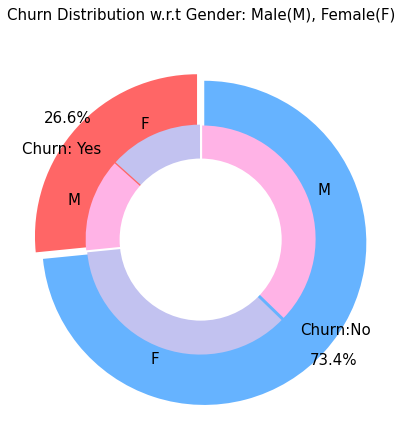

In [6]:
plt.figure(figsize=(6, 6))
labels =["Churn: Yes","Churn:No"]
values = [1869,5163]
labels_gender = ["F","M","F","M"]
sizes_gender = [939,930 , 2544,2619]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6']
explode = (0.3,0.3) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Churn Distribution w.r.t Gender: Male(M), Female(F)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()

Showing Missing Values use MSNO

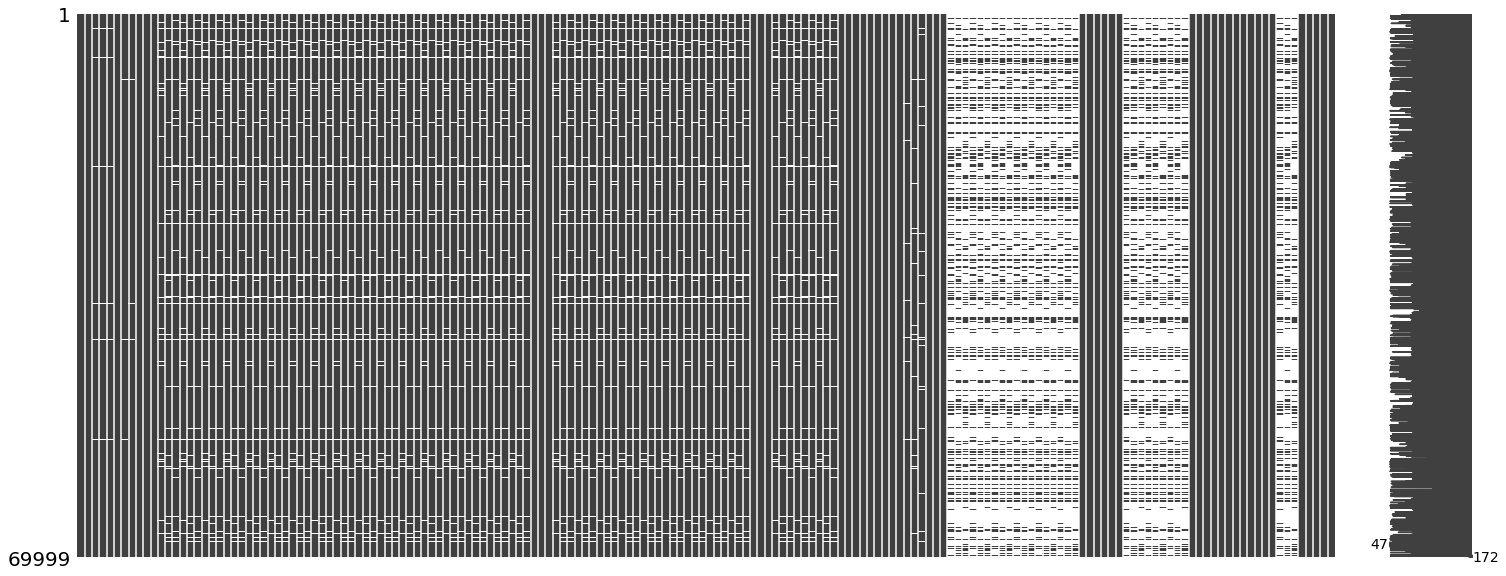

In [7]:
msno.matrix(train_df)

In [8]:
train_df.describe(include='all')

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999,69600,69266,69999.000000,69999.000000,...,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
unique,NaN,NaN,NaN,NaN,NaN,1,1,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,6/30/2014,7/31/2014,8/31/2014,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,69999,69600,69266,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,34999.000000,109.0,0.0,0.0,0.0,NaN,NaN,NaN,283.134365,278.185912,...,0.081444,0.085487,0.916325,0.909544,0.890319,1220.639709,68.108597,65.935830,60.07674,0.101887
std,20207.115084,0.0,0.0,0.0,0.0,NaN,NaN,NaN,334.213918,344.366927,...,0.634547,0.680035,0.276907,0.286842,0.312501,952.426321,269.328659,267.899034,257.22681,0.302502
min,0.000000,109.0,0.0,0.0,0.0,NaN,NaN,NaN,-2258.709000,-1289.715000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,17499.500000,109.0,0.0,0.0,0.0,NaN,NaN,NaN,93.581000,86.714000,...,0.000000,0.000000,1.000000,1.000000,1.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,34999.000000,109.0,0.0,0.0,0.0,NaN,NaN,NaN,197.484000,191.588000,...,0.000000,0.000000,1.000000,1.000000,1.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,52498.500000,109.0,0.0,0.0,0.0,NaN,NaN,NaN,370.791000,365.369500,...,0.000000,0.000000,1.000000,1.000000,1.000000,1813.000000,0.000000,0.000000,0.00000,0.000000


# Data Preprocessing

#### Helper functions for the data preprocessing

In [9]:
def get_cols_split(df):
    '''
    - This method reads the columns in the given dataframe and splits them into various categories such as months, date related cols 
      and other common cols  
    - Then returns the column lists as output for each of these categories. 
    '''
    col_len = len(df.columns)

    jun_cols = []
    jul_cols = []
    aug_cols = []
    common_cols = []
    date_cols = []
    
    for i in range(0, col_len):
        if any(pd.Series(df.columns[i]).str.contains('_6|jun')):
            jun_cols.append(df.columns[i])
        elif any(pd.Series(df.columns[i]).str.contains('_7|jul')):
            jul_cols.append(df.columns[i])
        elif any(pd.Series(df.columns[i]).str.contains('_8|aug')):
            aug_cols.append(df.columns[i])
        else:
            common_cols.append(df.columns[i])
        
        if any(pd.Series(df.columns[i]).str.contains('date')):
            date_cols.append(df.columns[i])
            
    return jun_cols,jul_cols,aug_cols,common_cols,date_cols

In [10]:
# def get_cols_sub_split(col_list):
#     '''
#     - This method gets the columns list as input and splits them into various sub-categories such as call_usage, recharge columns, 
#       incoming and outgoing related cols  
#     - Then returns the column lists as output for each of these sub-categories. 
#     '''
#     call_usage_cols = []
#     recharge_cols = []
#     ic_usage_cols = []
#     og_usage_cols = []

#     call_usage_search_for = ['og','ic','mou']

#     for i in range(0, len(col_list)):
#         if any(pd.Series(col_list[i]).str.contains('|'.join(['rech','rch']))):
#             recharge_cols.append(col_list[i])
#         elif any(pd.Series(col_list[i]).str.contains('|'.join(call_usage_search_for))):
#             call_usage_cols.append(col_list[i])

#         if any(pd.Series(col_list[i]).str.contains('ic')):
#             ic_usage_cols.append(col_list[i])
#         elif any(pd.Series(col_list[i]).str.contains('og')):
#             og_usage_cols.append(col_list[i])
            
#     return call_usage_cols,recharge_cols,ic_usage_cols,og_usage_cols            

### Get only the high value customers

As per the objective, let's first filter out the dataset to have only the high value customer records.

In [11]:
# Get the average recharge amount for 6 and 7 month
train_df['avg_rech_amt_6_7'] = (train_df['total_rech_amt_6'] + train_df['total_rech_amt_7'] ) / 2

# Get the data greater than 70th percentile of average recharge amount
train_df = train_df.loc[(train_df['avg_rech_amt_6_7'] > np.percentile(train_df['avg_rech_amt_6_7'], 70))]

# drop the average column
train_df.drop(['avg_rech_amt_6_7'], axis=1, inplace=True)

print(train_df.shape)

(20951, 172)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


To filter the high value customer records,

* Derive the column of average reacharge amount for Jun and Jul month(the good phase)
* Take only the records that is more than the 70th percentile of the average recharge amount.
* Drop the newly derived column which is not required.
* Print the count of rows and columns of new filtered dataframe.

### Classify the churn and non-churn customers

Now tag the churned customers as 1 else 0 based on the Aug month and derive the Churn(Response) column for the given dataset.

In [12]:
# mark the rows as churn if the sum of the total mou and vol of 8 month is 0
tag_churn_cols = ['total_ic_mou_8', 'total_og_mou_8', 'vol_2g_mb_8', 'vol_3g_mb_8']
train_df['churn'] = np.where(train_df[tag_churn_cols].sum(axis=1) == 0, 1, 0 )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


To tag the churned customers,
* Take the columns such as 'total_ic_mou_8', 'total_og_mou_8', 'vol_2g_mb_8', 'vol_3g_mb_8'
* Find the sum of above columns values for each records
* Tag the customer record as Churned(1) if the sum value is 0 else Non-Churned(0) and derive the Churn column

Now check for the count of churned customers in the obtained dataset.

In [13]:
train_df['churn'].value_counts()

0    19743
1     1208
Name: churn, dtype: int64

From around 20k customer records, we have about more than 1208 churned customers. 

The churn rate would be as follows:

In [14]:
print('Churn Rate : {0}%'.format(round(((sum(train_df['churn'])/len(train_df['churn']))*100),2)))

Churn Rate : 5.77%


Churn rate is less than 6% of the overall data available. This indicates that we would need to handle the class imbalance in this classification problem.

#### Check for the unwanted columns and remove

Now we can check for the less info columns or sparsed columns and remove them if not required.

In [15]:
# Get the unique count
for col in train_df.columns:
    print(col, len(train_df[col].unique()))

id 20951
circle_id 1
loc_og_t2o_mou 2
std_og_t2o_mou 2
loc_ic_t2o_mou 2
last_date_of_month_6 1
last_date_of_month_7 2
last_date_of_month_8 2
arpu_6 20545
arpu_7 20532
arpu_8 19945
onnet_mou_6 14611
onnet_mou_7 14670
onnet_mou_8 13647
offnet_mou_6 16950
offnet_mou_7 17029
offnet_mou_8 16256
roam_ic_mou_6 3373
roam_ic_mou_7 2838
roam_ic_mou_8 2788
roam_og_mou_6 3920
roam_og_mou_7 3315
roam_og_mou_8 3324
loc_og_t2t_mou_6 9140
loc_og_t2t_mou_7 9110
loc_og_t2t_mou_8 8811
loc_og_t2m_mou_6 13258
loc_og_t2m_mou_7 13355
loc_og_t2m_mou_8 12771
loc_og_t2f_mou_6 2772
loc_og_t2f_mou_7 2767
loc_og_t2f_mou_8 2654
loc_og_t2c_mou_6 1415
loc_og_t2c_mou_7 1467
loc_og_t2c_mou_8 1471
loc_og_mou_6 15121
loc_og_mou_7 15229
loc_og_mou_8 14474
std_og_t2t_mou_6 9712
std_og_t2t_mou_7 9823
std_og_t2t_mou_8 8928
std_og_t2m_mou_6 11250
std_og_t2m_mou_7 11238
std_og_t2m_mou_8 10311
std_og_t2f_mou_6 1421
std_og_t2f_mou_7 1371
std_og_t2f_mou_8 1304
std_og_t2c_mou_6 2
std_og_t2c_mou_7 2
std_og_t2c_mou_8 2
std_og_mou_6 

We can observe from the above result that,

* Less Info columns
    * circle_id
    * last_date_of_month_6
    * last_date_of_month_7
    * last_date_of_month_8
    * loc_og_t2o_mou
    * std_og_t2o_mou
    * loc_ic_t2o_mou
    * std_og_t2c_mou_6
    * std_og_t2c_mou_7
    * std_og_t2c_mou_8
    * std_ic_t2o_mou_6
    * std_ic_t2o_mou_7
    * std_ic_t2o_mou_8
    
Let's take a look at some sample records of the above columns.

In [16]:
train_df[['circle_id','last_date_of_month_6','last_date_of_month_7','last_date_of_month_8',\
           'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou','std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8',\
           'std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8']].head(5)

,circle_id,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8
12,109,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,109,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,109,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,109,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,109,6/30/2014,7/31/2014,8/31/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


It seems, we can very well remove the above listed columns from the dataset.

In [17]:
# create column name list by types of columns
id_cols = ['id', 'circle_id']

date_cols = ['last_date_of_month_6',
             'last_date_of_month_7',
             'last_date_of_month_8',
             'date_of_last_rech_6',
             'date_of_last_rech_7',
             'date_of_last_rech_8',
             'date_of_last_rech_data_6',
             'date_of_last_rech_data_7',
             'date_of_last_rech_data_8'
            ]

In [18]:
# drop id and date columns
print("Shape before dropping: ", train_df.shape)
train_df = train_df.drop(id_cols + date_cols, axis=1)
print("Shape after dropping: ", train_df.shape)

Shape before dropping:  (20951, 173)
Shape after dropping:  (20951, 162)


In [19]:
from fancyimpute import IterativeImputer as MICE

df_cols = train_df.columns
print('Total Columns :',len(df_cols))

train_df_inmput = MICE(verbose=2, max_iter=1).fit_transform(train_df)

Total Columns : 162
[IterativeImputer] Completing matrix with shape (20951, 162)
[IterativeImputer] Ending imputation round 1/1, elapsed time 113.86
[IterativeImputer] Change: 11259.238202906068, scaled tolerance: 45.735400000000006 


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


In [20]:
train_df.shape

(20951, 162)

In [21]:
# convert imputed numpy array to pandas dataframe
train_df = pd.DataFrame(train_df_inmput, columns=df_cols)
print(train_df.shape)
print(train_df.isnull().sum()*100/train_df.shape[0])

(20951, 162)
loc_og_t2o_mou       0.0
std_og_t2o_mou       0.0
loc_ic_t2o_mou       0.0
arpu_6               0.0
arpu_7               0.0
                    ... 
aug_vbc_3g           0.0
jul_vbc_3g           0.0
jun_vbc_3g           0.0
churn_probability    0.0
churn                0.0
Length: 162, dtype: float64


Now let's check for the recharge columns value.

In [22]:
train_df[['total_rech_data_6','av_rech_amt_data_6','max_rech_data_6']].head()

,total_rech_data_6,av_rech_amt_data_6,max_rech_data_6
0,1.646633,187.152043,145.611929
1,1.000000,154.000000,154.000000
2,1.646633,187.905615,110.643491
3,1.000000,23.000000,23.000000
4,1.646633,188.076006,161.742066


Found that the average recharge amount for data columns actually depicts the total amount rather than average value. So we will rename the columns to proper name.

In [23]:
#Rename the cols to correct name
train_df = train_df.rename(columns={'av_rech_amt_data_6':'total_rech_amt_data_6','av_rech_amt_data_7':'total_rech_amt_data_7','av_rech_amt_data_8':'total_rech_amt_data_8'})

# Handling Missing Values

Now we will pass the dataframe to **get_cols_split** helper function and get the column categories.

In [24]:
# Get the columns split to months
jun_cols, jul_cols, aug_cols, common_cols, date_cols = get_cols_split(train_df)

Few date columns have some missing values. But let's leave that as is for now and will use that later point in time.

# EDA

#### Churn (Target Variable)

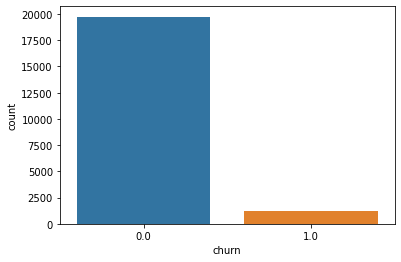

In [25]:
sns.countplot(x='churn', data=train_df)

As we observed earlier, churn rate is low in the overall dataset. So we would need to handle the class imbalance.

#### Age on Network (aon)

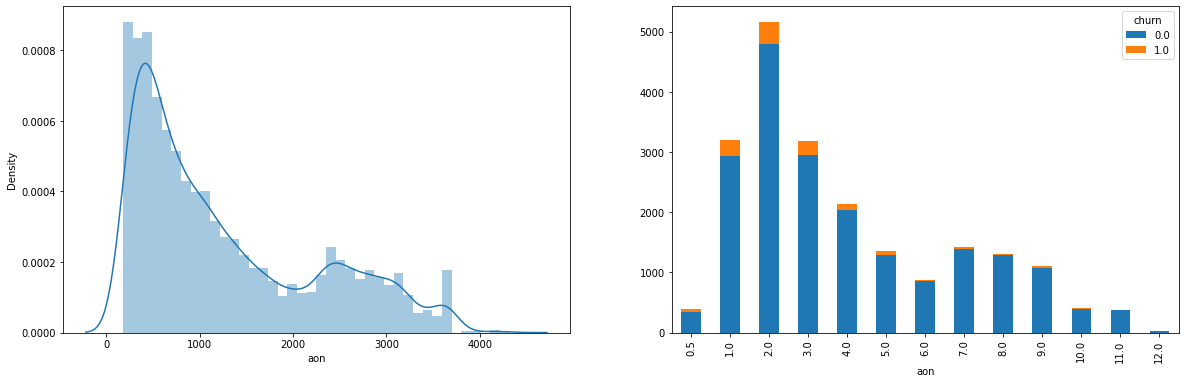

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 6))

# distribution plot for aon
sns.distplot(train_df['aon'], ax=ax1)

bins = [0, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
labels = [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
pd.crosstab(pd.cut(round(((train_df['aon']/30)/12),1), bins = bins, labels = labels ), train_df['churn']).plot(kind='bar', stacked=True, ax = ax2)

* We could see more number of observations between 1 and 3 years.
* Also churn rate is high during this range than the others.

#### Incoming Calls Usage

,loc_ic_mou_6,std_ic_mou_6,isd_ic_mou_6,roam_ic_mou_6,spl_ic_mou_6,ic_others_6,total_ic_mou_6
count,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000
mean,243.813447,50.554202,10.808016,18.124439,-0.947902,1.233052,305.397397
std,308.886258,133.296344,62.542498,78.318339,9.821732,15.909637,355.300246
min,0.000000,-11.144162,0.000000,0.000000,-95.834365,0.000000,0.000000
25%,59.775000,2.670000,0.000000,0.000000,0.000000,0.000000,89.315000
50%,150.180000,15.080000,0.000000,0.000000,0.000000,0.000000,203.180000
75%,314.210000,47.550000,0.000000,0.000000,0.000000,0.100000,391.645000
max,5852.610000,3929.240000,2138.980000,2613.310000,19.760000,1344.140000,6633.180000


,loc_ic_mou_7,std_ic_mou_7,isd_ic_mou_7,roam_ic_mou_7,spl_ic_mou_7,ic_others_7,total_ic_mou_7
count,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000
mean,245.697790,52.598427,12.008614,14.440303,-0.874554,1.495784,310.951673
std,305.852093,146.640982,68.791353,78.912369,8.933079,16.498105,359.733321
min,0.000000,-10.330007,0.000000,-15.339272,-90.288564,0.000000,0.000000
25%,65.910000,2.830000,0.000000,0.000000,0.000000,0.000000,98.150000
50%,153.690000,16.230000,0.000000,0.000000,0.000000,0.000000,209.560000
75%,315.440000,50.400000,0.000000,0.000000,0.000000,0.060000,393.320000
max,6466.740000,6745.760000,2631.340000,3813.290000,13.460000,1495.940000,7279.080000


,loc_ic_mou_8,std_ic_mou_8,isd_ic_mou_8,roam_ic_mou_8,spl_ic_mou_8,ic_others_8,total_ic_mou_8
count,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000
mean,234.863333,47.035145,11.791879,15.778574,-2.712074,1.296621,292.471460
std,299.057118,132.735967,70.449542,77.031781,15.294026,14.131618,351.408519
min,0.000000,-13.874009,0.000000,0.000000,-88.046758,0.000000,0.000000
25%,59.580000,1.450000,0.000000,0.000000,0.000000,0.000000,78.800000
50%,142.740000,12.560000,0.000000,0.000000,0.000000,0.000000,194.040000
75%,301.800000,43.335000,0.000000,0.000000,0.000000,0.130000,377.410000
max,5748.810000,3777.940000,3432.880000,4169.810000,1.260000,1209.860000,5775.860000


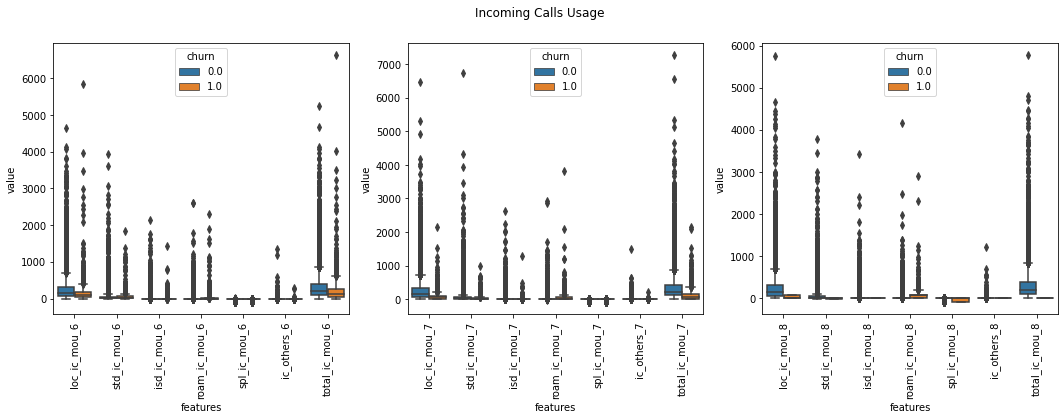

In [27]:
cols = [['loc_ic_mou_6','std_ic_mou_6','isd_ic_mou_6','roam_ic_mou_6','spl_ic_mou_6','ic_others_6','total_ic_mou_6'],
        ['loc_ic_mou_7','std_ic_mou_7','isd_ic_mou_7','roam_ic_mou_7','spl_ic_mou_7','ic_others_7','total_ic_mou_7'],
        ['loc_ic_mou_8','std_ic_mou_8','isd_ic_mou_8','roam_ic_mou_8','spl_ic_mou_8','ic_others_8','total_ic_mou_8']]

# column description stats
for i in range(0,3):
    display(train_df[cols[i]].describe())

# plot for the incoming calls usage
plt.figure(figsize=(18, 5))
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([train_df[cols[i]], train_df['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Incoming Calls Usage')

Almost all the Incoming calls usage columns seem to have outliers at the top percentile.

#### Outgoing Calls Usage

,loc_og_mou_6,std_og_mou_6,isd_og_mou_6,roam_og_mou_6,spl_og_mou_6,og_others_6,total_og_mou_6
count,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000
mean,281.729315,404.321084,-0.205799,30.388658,6.035844,0.701001,692.810153
std,382.502106,608.414568,59.103095,122.242220,19.276001,2.217239,663.591715
min,-42.822570,0.000000,-249.628423,0.000000,0.000000,0.000000,0.000000
25%,50.845000,7.360000,0.000000,0.000000,0.000000,0.000000,269.395000
50%,165.930000,142.010000,0.000000,0.000000,0.310000,0.000000,515.790000
75%,372.875000,587.000000,0.000000,0.000000,5.560000,0.000000,908.850000
max,10643.380000,8432.990000,5900.660000,3775.110000,1023.210000,74.210000,10674.030000


,loc_og_mou_7,std_og_mou_7,isd_og_mou_7,roam_og_mou_7,spl_og_mou_7,og_others_7,total_og_mou_7
count,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.00000
mean,281.337440,422.245982,0.175045,22.287976,7.482586,0.033089,711.48308
std,374.819033,636.391399,56.670721,98.147123,24.078684,1.688008,683.68975
min,-87.905370,0.000000,-219.598331,-2.032017,0.000000,0.000000,0.00000
25%,56.030000,6.970000,0.000000,0.000000,0.000000,0.000000,277.50500
50%,170.540000,148.060000,0.000000,0.000000,0.860000,0.000000,527.71000
75%,373.410000,625.820000,0.000000,0.000000,7.482651,0.000000,933.15500
max,7674.780000,8155.530000,5490.280000,2812.040000,1265.790000,221.940000,8285.64000


,loc_og_mou_8,std_og_mou_8,isd_og_mou_8,roam_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8
count,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000
mean,257.248495,364.945783,-3.957724,21.386541,7.134517,0.059817,626.295317
std,369.312013,612.798926,62.687961,106.078903,22.449678,3.088447,687.363202
min,-74.665476,0.000000,-198.559369,-4.538673,0.000000,0.000000,0.000000
25%,38.035000,3.795000,0.000000,0.000000,0.000000,0.000000,190.225000
50%,148.590000,103.240000,0.000000,0.000000,0.880000,0.000000,436.580000
75%,347.155000,491.520000,0.000000,0.000000,7.132269,0.000000,835.835000
max,11039.910000,13980.060000,5681.540000,5337.040000,954.510000,394.930000,14043.060000


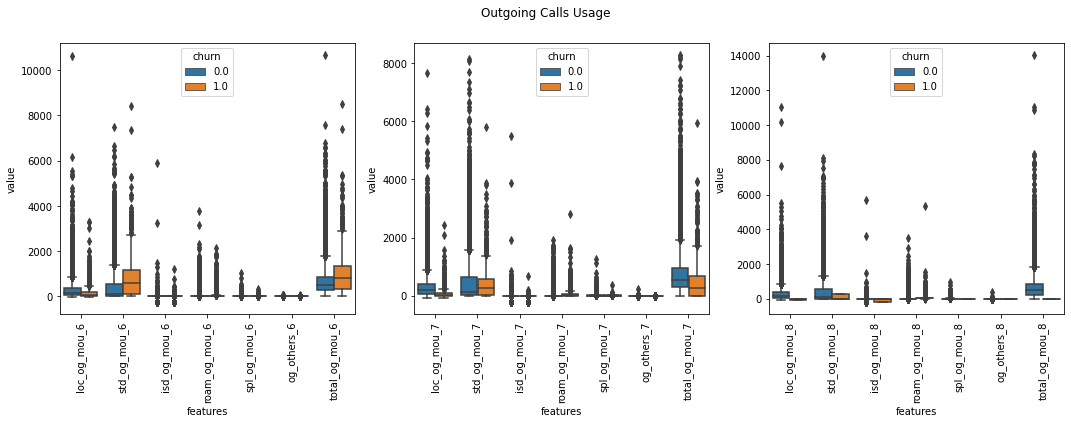

In [28]:
cols = [['loc_og_mou_6','std_og_mou_6','isd_og_mou_6','roam_og_mou_6','spl_og_mou_6','og_others_6','total_og_mou_6'],
        ['loc_og_mou_7','std_og_mou_7','isd_og_mou_7','roam_og_mou_7','spl_og_mou_7','og_others_7','total_og_mou_7'],
        ['loc_og_mou_8','std_og_mou_8','isd_og_mou_8','roam_og_mou_8','spl_og_mou_8','og_others_8','total_og_mou_8']]

# column description stats
for i in range(0,3):
    display(train_df[cols[i]].describe())

# plot for the outgoing calls usage
plt.figure(figsize=(18, 5))
#ic call usage
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([train_df[cols[i]], train_df['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Outgoing Calls Usage')

Outgoing calls usage columns also seem to have outliers at the top percentile.

#### Operatorwise Calls Usage

,onnet_mou_6,offnet_mou_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,std_ic_t2t_mou_6,std_ic_t2m_mou_6,std_ic_t2f_mou_6
count,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000
mean,297.803335,426.438171,69.299235,160.372949,15.761374,16.271996,32.257157,2.935156
std,467.488445,467.886010,157.010725,216.773913,44.483967,71.163732,97.692273,20.868977
min,-125.412142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.130000,144.070000,9.000000,35.110000,0.000000,0.000000,0.610000,0.000000
50%,126.580000,293.390000,30.160000,96.990000,2.160000,1.240000,7.540000,0.000000
75%,353.885000,530.060000,76.370000,202.700000,13.510000,11.150000,29.270000,0.280000
max,7376.710000,8362.360000,4111.980000,4450.740000,1373.090000,3038.340000,3613.980000,1351.110000


,loc_og_t2t_mou_6,loc_og_t2m_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6
count,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000
mean,94.536184,183.056166,6.995275,1.387861,194.598597,209.199562,2.027059
std,238.531008,248.378341,20.889659,7.735357,414.293123,413.486597,12.825786
min,0.000000,0.000000,0.000000,-25.340379,0.000000,0.000000,0.000000
25%,8.990000,32.190000,0.000000,0.000000,0.000000,2.160000,0.000000
50%,33.790000,105.210000,0.410000,0.000000,15.490000,42.560000,0.000000
75%,91.050000,238.800000,5.470000,0.000000,196.201852,216.050000,0.000000
max,6431.330000,4696.830000,617.580000,342.860000,7366.580000,8314.760000,628.560000


,onnet_mou_7,offnet_mou_7,loc_ic_t2t_mou_7,loc_ic_t2m_mou_7,loc_ic_t2f_mou_7,std_ic_t2t_mou_7,std_ic_t2m_mou_7,std_ic_t2f_mou_7
count,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000
mean,305.256852,428.902829,70.182674,160.226957,16.737601,16.930057,33.523660,2.991262
std,489.031635,477.596224,165.713519,208.089301,49.857317,82.387740,102.837849,19.136956
min,-366.096027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.190000,142.280000,10.140000,39.800000,0.000000,0.000000,0.630000,0.000000
50%,125.640000,290.210000,31.030000,99.340000,2.410000,1.400000,7.980000,0.000000
75%,359.720000,539.085000,74.180000,203.285000,13.960000,11.670000,30.910000,0.330000
max,8157.780000,7043.980000,5709.590000,4027.030000,1983.010000,4708.710000,3470.380000,1136.080000


,loc_og_t2t_mou_7,loc_og_t2m_mou_7,loc_og_t2f_mou_7,loc_og_t2c_mou_7,std_og_t2t_mou_7,std_og_t2m_mou_7,std_og_t2f_mou_7
count,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000
mean,95.525938,181.561293,7.121180,1.551622,203.599459,218.108332,1.954866
std,250.277777,233.479766,21.288674,9.880281,433.953149,433.656624,12.774931
min,0.000000,0.000000,0.000000,-47.792563,0.000000,0.000000,0.000000
25%,9.660000,35.130000,0.000000,0.000000,0.000000,1.930000,0.000000
50%,33.110000,107.760000,0.460000,0.000000,16.390000,42.060000,0.000000
75%,91.360000,238.420000,5.610000,0.100000,203.491360,227.760000,0.000000
max,7400.660000,4557.140000,815.330000,569.710000,8133.660000,6622.540000,465.790000


,onnet_mou_8,offnet_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8
count,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000
mean,266.268682,387.366560,67.764451,156.694229,15.254991,16.206836,30.897852,2.708910
std,475.497932,467.959582,156.377345,206.761446,44.013336,69.456842,95.924863,19.564442
min,-825.591056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.020000,112.735000,8.710000,35.980000,0.000000,0.000000,0.310000,0.000000
50%,99.710000,263.290000,30.180000,99.090000,2.440000,0.980000,7.030000,0.000000
75%,298.520000,484.020000,70.160000,196.085000,14.440000,11.280000,30.740000,0.500000
max,10752.560000,14007.340000,4003.210000,5738.460000,1588.530000,3423.390000,2879.310000,1394.890000


,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8
count,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000,20951.000000
mean,87.708012,171.422752,6.685153,1.253670,178.976939,188.205071,1.811691
std,240.356182,227.349550,19.820231,7.780803,413.058731,413.285178,11.115923
min,0.000000,0.000000,0.000000,-23.626170,0.000000,0.000000,0.000000
25%,7.680000,28.550000,0.000000,0.000000,0.000000,0.700000,0.000000
50%,28.540000,102.430000,0.430000,0.000000,10.390000,31.830000,0.000000
75%,84.035000,223.290000,5.910000,0.030000,178.700165,188.202355,0.000000
max,10752.560000,4961.330000,588.290000,351.830000,8014.430000,13950.040000,354.160000


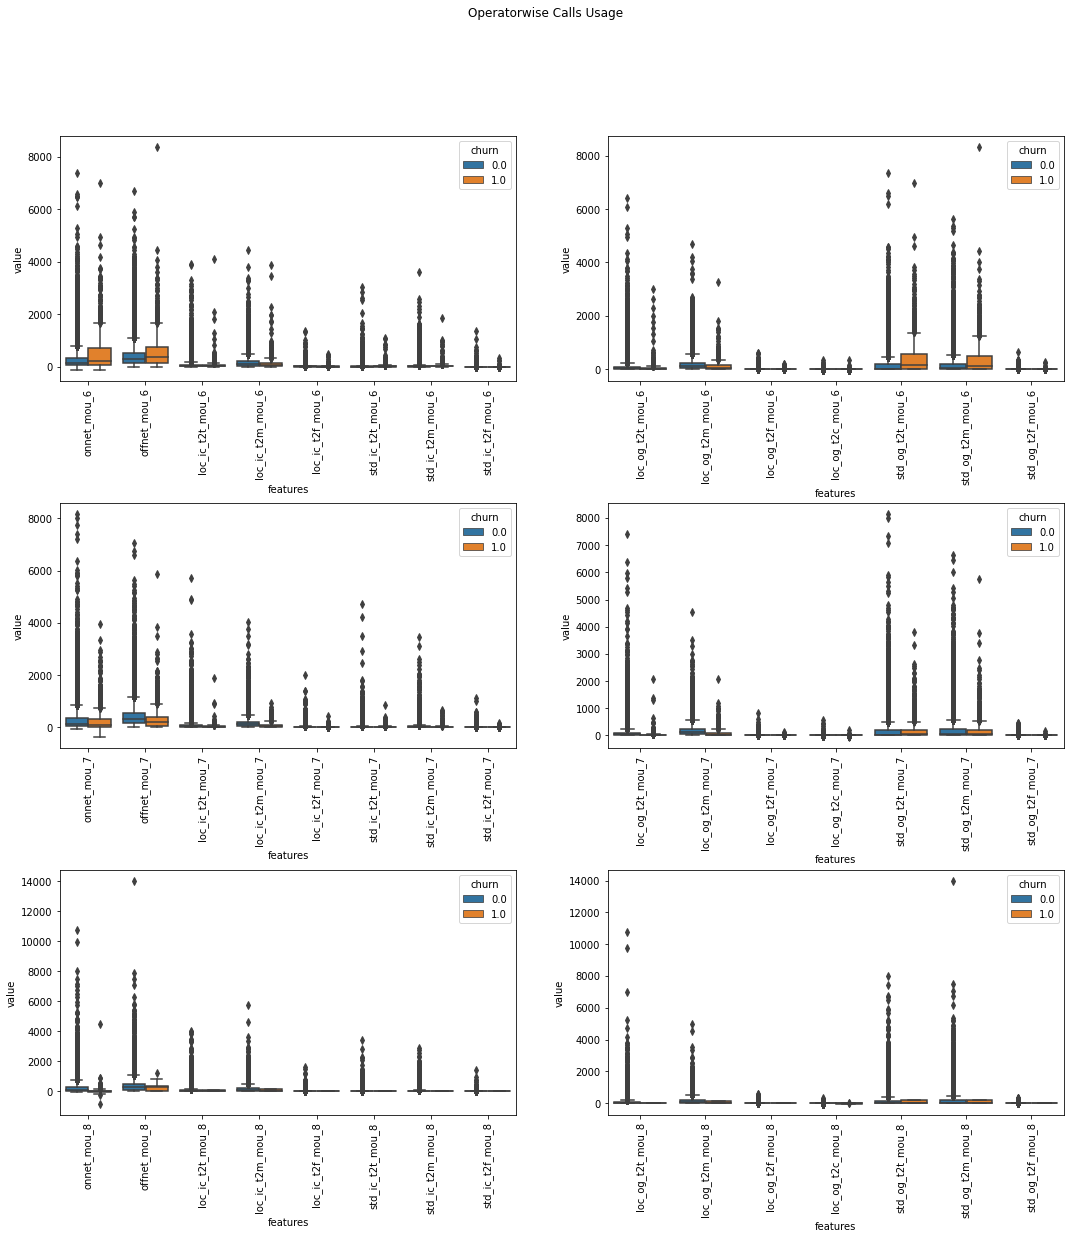

In [29]:
cols = [['onnet_mou_6','offnet_mou_6','loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6','std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6'],
        ['loc_og_t2t_mou_6','loc_og_t2m_mou_6','loc_og_t2f_mou_6','loc_og_t2c_mou_6','std_og_t2t_mou_6','std_og_t2m_mou_6','std_og_t2f_mou_6'],
        ['onnet_mou_7','offnet_mou_7','loc_ic_t2t_mou_7','loc_ic_t2m_mou_7','loc_ic_t2f_mou_7','std_ic_t2t_mou_7','std_ic_t2m_mou_7','std_ic_t2f_mou_7'],
        ['loc_og_t2t_mou_7','loc_og_t2m_mou_7','loc_og_t2f_mou_7','loc_og_t2c_mou_7','std_og_t2t_mou_7','std_og_t2m_mou_7','std_og_t2f_mou_7'],
        ['onnet_mou_8','offnet_mou_8','loc_ic_t2t_mou_8','loc_ic_t2m_mou_8','loc_ic_t2f_mou_8','std_ic_t2t_mou_8','std_ic_t2m_mou_8','std_ic_t2f_mou_8'],
        ['loc_og_t2t_mou_8','loc_og_t2m_mou_8','loc_og_t2f_mou_8','loc_og_t2c_mou_8','std_og_t2t_mou_8','std_og_t2m_mou_8','std_og_t2f_mou_8']]

# column description stats
for i in range(0,6):
    display(train_df[cols[i]].describe())

# plot for the operatorwise calls usage
plt.figure(figsize=(18, 18))
plt.subplots_adjust(hspace=0.5)
for i in range(0,6):
    plt.subplot(3,2,i+1)
    X = pd.concat([train_df[cols[i]], train_df['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Operatorwise Calls Usage')

Operatorwise calls usage columns also seem to have outliers at the top percentile.

#### Recharge Amount

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8
count,20951.000000,20951.000000,20951.000000
mean,699.367476,694.331010,612.843540
std,554.328224,571.255145,627.344722
min,0.000000,0.000000,0.000000
25%,432.000000,427.000000,308.000000
50%,586.000000,583.000000,520.000000
75%,840.000000,834.000000,787.000000
max,35190.000000,40335.000000,45320.000000


,total_rech_amt_voice_6,total_rech_amt_voice_7,total_rech_amt_voice_8
count,20951.000000,20951.000000,20951.000000
mean,499.845607,485.377160,439.384478
std,542.079789,549.730747,589.602699
min,0.000000,0.000000,0.000000
25%,235.457600,222.021578,130.000000
50%,393.044561,380.000000,341.418900
75%,638.000000,616.620626,596.000000
max,35167.836815,40048.039288,44731.428865


,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8
count,20951.000000,20951.000000,20951.000000
mean,205.453230,216.261917,191.262472
std,152.885937,161.433805,152.522293
min,-1035.003453,-497.727582,-148.979557
25%,165.008313,173.258831,154.000000
50%,186.960551,194.792572,167.238843
75%,199.187593,209.852771,183.561274
max,5920.000000,4365.000000,4061.000000


,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8
count,20951.000000,20951.000000,20951.000000
mean,171.118419,174.157606,162.239034
std,176.935155,173.788102,167.636398
min,0.000000,0.000000,0.000000
25%,110.000000,110.000000,67.000000
50%,120.000000,128.000000,130.000000
75%,200.000000,200.000000,198.000000
max,4010.000000,3299.000000,4449.000000


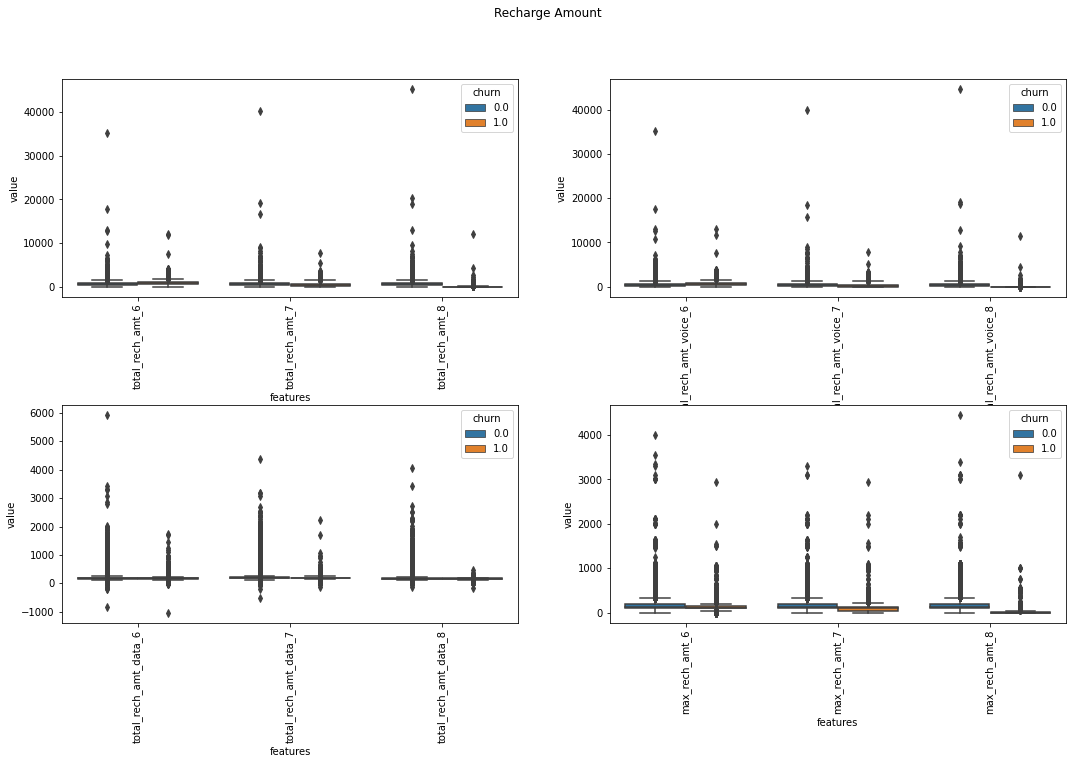

In [30]:
# Let's derive total recharge amount for voice with the diff recharge amount of total and data
train_df['total_rech_amt_voice_6'] = np.where((train_df['total_rech_amt_6'] >= train_df['total_rech_amt_data_6']), (train_df['total_rech_amt_6'] - train_df['total_rech_amt_data_6']), 0)
train_df['total_rech_amt_voice_7'] = np.where((train_df['total_rech_amt_7'] >= train_df['total_rech_amt_data_7']), (train_df['total_rech_amt_7'] - train_df['total_rech_amt_data_7']), 0)
train_df['total_rech_amt_voice_8'] = np.where((train_df['total_rech_amt_8'] >= train_df['total_rech_amt_data_8']), (train_df['total_rech_amt_8'] - train_df['total_rech_amt_data_8']), 0)

cols = [
        ['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8'],
        ['total_rech_amt_voice_6','total_rech_amt_voice_7','total_rech_amt_voice_8'],
        ['total_rech_amt_data_6','total_rech_amt_data_7','total_rech_amt_data_8'],
        ['max_rech_amt_6','max_rech_amt_7','max_rech_amt_8']
       ]

# column description stats
for i in range(0,4):
    display(train_df[cols[i]].describe())

# plot for the recharge amount columns
plt.figure(figsize=(18, 10))
plt.subplots_adjust(hspace=0.5)
for i in range(0,4):
    plt.subplot(2,2,i+1)
    X = pd.concat([train_df[cols[i]], train_df['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Recharge Amount')

Recharge amount columns also seem to have outliers at the top percentile.

#### Recharge Count

,total_rech_num_6,total_rech_num_7,total_rech_num_8
count,20951.000000,20951.000000,20951.000000
mean,12.145100,11.921627,10.224763
std,9.447342,9.562080,9.444794
min,0.000000,0.000000,0.000000
25%,6.000000,6.000000,4.000000
50%,9.000000,9.000000,8.000000
75%,15.000000,15.000000,13.000000
max,170.000000,138.000000,138.000000


,total_rech_data_6,total_rech_data_7,total_rech_data_8
count,20951.000000,20951.000000,20951.000000
mean,1.955494,2.158720,2.097720
std,1.854867,2.108082,2.099148
min,1.000000,1.000000,1.000000
25%,1.646633,1.808080,1.751998
50%,1.646633,1.808080,1.751998
75%,1.646633,1.808080,1.751998
max,61.000000,54.000000,60.000000


,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,20951.000000,20951.000000,20951.000000
mean,149.488268,147.916852,138.497618
std,82.676454,83.348679,82.524330
min,-371.365408,-139.464434,-729.831870
25%,128.429380,127.582542,116.673694
50%,145.928101,145.000000,135.526737
75%,160.552629,157.152694,154.000000
max,1555.000000,1555.000000,1555.000000


,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8
count,20951.000000,20951.000000,20951.000000
mean,0.986592,1.119503,1.114030
std,1.589684,1.813142,1.728994
min,0.000000,0.000000,0.000000
25%,0.595935,0.666229,0.656856
50%,0.595935,0.666229,0.656856
75%,1.000000,1.000000,1.000000
max,34.000000,48.000000,44.000000


,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8
count,20951.000000,20951.000000,20951.000000
mean,0.738648,0.796260,0.751755
std,1.001248,1.119119,1.143377
min,0.000000,0.000000,0.000000
25%,0.681519,0.746128,0.715659
50%,0.681519,0.746128,0.715659
75%,0.681519,0.746128,0.715659
max,29.000000,34.000000,45.000000


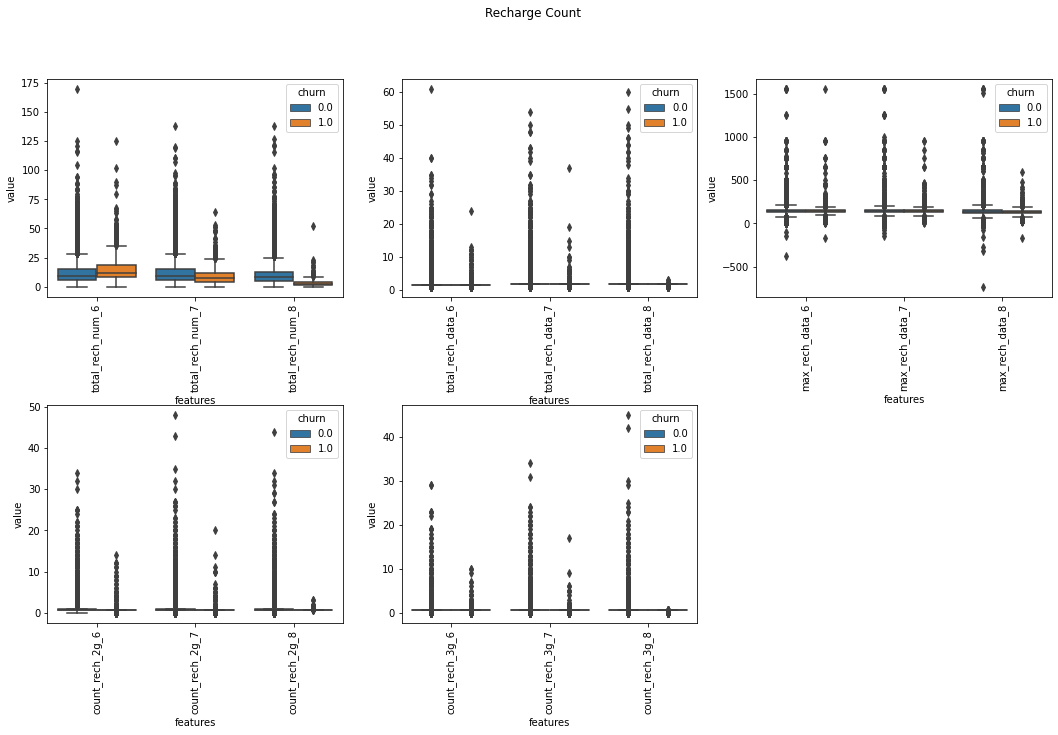

In [31]:
cols = [
        ['total_rech_num_6','total_rech_num_7','total_rech_num_8'],
        ['total_rech_data_6','total_rech_data_7','total_rech_data_8'],
        ['max_rech_data_6','max_rech_data_7','max_rech_data_8'],
        ['count_rech_2g_6','count_rech_2g_7','count_rech_2g_8'],
        ['count_rech_3g_6','count_rech_3g_7','count_rech_3g_8'] 
       ]

# column description stats
for i in range(0,5):
    display(train_df[cols[i]].describe())

# plot for the recharge count columns
plt.figure(figsize=(18, 10))
plt.subplots_adjust(hspace=0.5)
for i in range(0,5):
    plt.subplot(2,3,i+1)
    X = pd.concat([train_df[cols[i]], train_df['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Recharge Count')

Recharge count columns also seem to have outliers at the top percentile.

#### Average Revenue per User (Arpu)

,arpu_6,arpu_7,arpu_8
count,20951.000000,20951.000000,20951.000000
mean,588.085320,588.371778,533.841224
std,457.008578,478.940825,511.766776
min,-2258.709000,-1289.715000,-945.808000
25%,364.813000,365.371500,289.329500
50%,497.062000,494.181000,452.538000
75%,705.716500,700.798000,669.229500
max,27731.088000,35145.834000,33543.624000


,arpu_2g_6,arpu_2g_7,arpu_2g_8
count,20951.000000,20951.000000,20951.000000
mean,112.529325,114.136697,103.169569
std,138.881940,148.004365,136.807437
min,-124.286358,-116.973917,-329.825012
25%,77.471853,71.641837,60.194411
50%,95.625203,98.600138,87.523295
75%,109.527309,111.012937,100.615046
max,5054.350000,4809.360000,3467.170000


,arpu_3g_6,arpu_3g_7,arpu_3g_8
count,20951.000000,20951.000000,20951.000000
mean,126.446204,126.164066,114.520482
std,163.046945,166.374434,157.244416
min,-663.659680,-410.319958,-647.877413
25%,73.853575,75.802665,61.962155
50%,106.825911,106.833584,94.366392
75%,130.427728,126.430251,116.182843
max,5054.370000,4980.900000,3716.900000


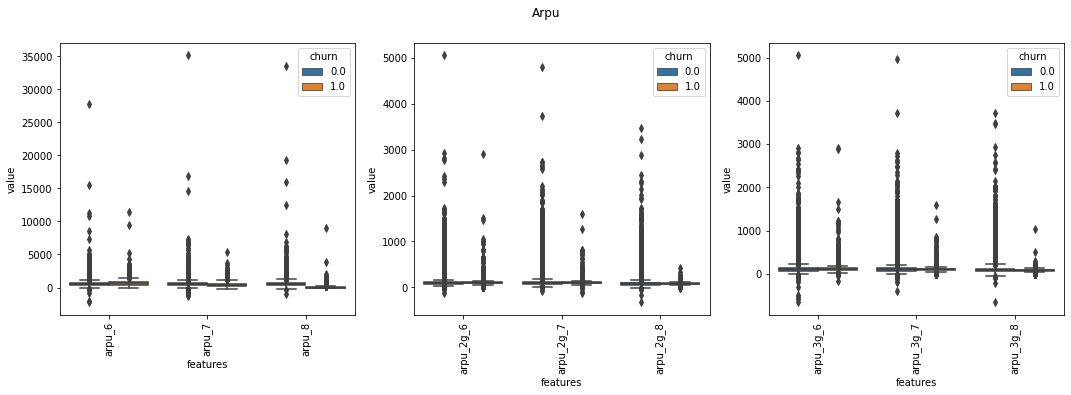

In [32]:
cols = [
        ['arpu_6','arpu_7','arpu_8'],
        ['arpu_2g_6','arpu_2g_7','arpu_2g_8'],
        ['arpu_3g_6','arpu_3g_7','arpu_3g_8']
       ]

# column description stats
for i in range(0,3):
    display(train_df[cols[i]].describe())

# plot for the arpu
plt.figure(figsize=(18, 5))
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([train_df[cols[i]], train_df['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Arpu')

arpu columns also seem to have outliers at the top percentile.

#### 2G and 3G

,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8
count,20951.000000,20951.000000,20951.000000
mean,78.291806,77.841886,69.113775
std,279.031654,277.668452,271.477639
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,13.910000,14.310000,9.200000
max,10285.900000,7873.550000,11117.610000


,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8
count,20951.000000,20951.000000,20951.000000
mean,260.005379,278.739322,268.915647
std,886.512517,884.015778,872.326261
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.270000,0.000000
max,45735.400000,28144.120000,30036.060000


,night_pck_user_6,night_pck_user_7,night_pck_user_8
count,20951.000000,20951.000000,20951.000000
mean,0.020844,0.020590,0.020123
std,0.111444,0.108002,0.101463
min,-0.358070,-0.532596,-0.692032
25%,0.000000,0.000000,0.000000
50%,0.001655,0.000000,0.000745
75%,0.016209,0.015031,0.015514
max,3.750459,1.000000,1.000000


,fb_user_6,fb_user_7,fb_user_8
count,20951.000000,20951.000000,20951.000000
mean,0.783269,0.727078,0.691943
std,0.249683,0.268935,0.288703
min,-0.439780,-0.778774,-0.211259
25%,0.695771,0.605910,0.562492
50%,0.764921,0.666061,0.630462
75%,1.000000,1.000000,1.000000
max,2.902449,2.277489,3.043763


,monthly_2g_6,monthly_2g_7,monthly_2g_8
count,20951.000000,20951.000000,20951.000000
mean,0.123288,0.131306,0.112644
std,0.371833,0.387130,0.354188
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,4.000000,5.000000,5.000000


,monthly_3g_6,monthly_3g_7,monthly_3g_8
count,20951.000000,20951.000000,20951.000000
mean,0.172068,0.182903,0.170111
std,0.564025,0.614429,0.578193
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,9.000000,16.000000,16.000000


,sachet_2g_6,sachet_2g_7,sachet_2g_8
count,20951.000000,20951.000000,20951.000000
mean,0.491623,0.579161,0.599924
std,1.671040,1.909035,1.832074
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,34.000000,48.000000,44.000000


,sachet_3g_6,sachet_3g_7,sachet_3g_8
count,20951.000000,20951.000000,20951.000000
mean,0.141521,0.155267,0.144241
std,0.893290,0.997704,1.029589
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,29.000000,33.000000,41.000000


,jun_vbc_3g,jul_vbc_3g,aug_vbc_3g
count,20951.000000,20951.000000,20951.000000
mean,121.716936,132.864616,128.285136
std,397.663887,405.704068,392.092779
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,1.190000,0.700000
max,11166.210000,9165.600000,12916.220000


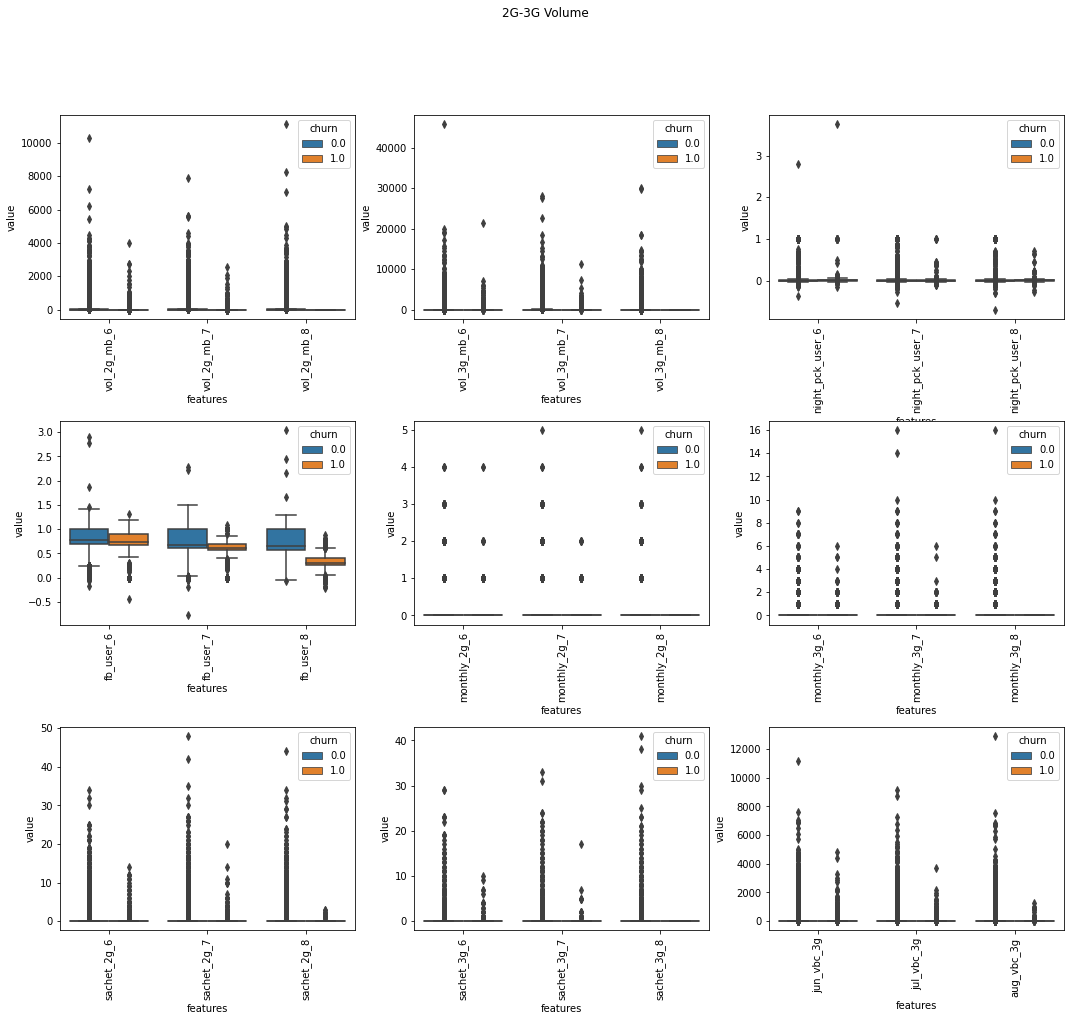

In [33]:
cols = [
        ['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8'],
        ['vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8'],
        ['night_pck_user_6','night_pck_user_7','night_pck_user_8'],
        ['fb_user_6','fb_user_7','fb_user_8'],
        ['monthly_2g_6','monthly_2g_7','monthly_2g_8'],
        ['monthly_3g_6','monthly_3g_7','monthly_3g_8'],
        ['sachet_2g_6','sachet_2g_7','sachet_2g_8'],
        ['sachet_3g_6','sachet_3g_7','sachet_3g_8'],
        ['jun_vbc_3g','jul_vbc_3g','aug_vbc_3g']
       ]

# column description stats
for i in range(0,9):
    display(train_df[cols[i]].describe())

# plot for the 2g-3g volume
plt.figure(figsize=(18, 15))
plt.subplots_adjust(hspace=0.5)
for i in range(0,9):
    plt.subplot(3,3,i+1)
    X = pd.concat([train_df[cols[i]], train_df['churn']], axis=1)
    X = pd.melt(X,id_vars="churn",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('2G-3G Volume')

2G and 3G volume columns also seem to have outliers at the top percentile.

# Outliers Treatment

### Cap the outliers at the top percentile

We'll need to cap the outliers at the 99th percentile for the below columns.

In [34]:
cols_to_exclude = ['night_pck_user_6','night_pck_user_7','night_pck_user_8',
                   'fb_user_6','fb_user_7','fb_user_8',
                   'monthly_2g_6','monthly_2g_7','monthly_2g_8',
                   'monthly_3g_6','monthly_3g_7','monthly_3g_8',
                   'sachet_2g_6','sachet_2g_7','sachet_2g_8',
                   'sachet_3g_6','sachet_3g_7','sachet_3g_8',
                   'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8',
                   'spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8','spl_og_mou_6','og_others_6','spl_og_mou_7','og_others_7','spl_og_mou_8','og_others_8',
                   'loc_og_t2c_mou_6','std_og_t2f_mou_6','std_ic_t2f_mou_6','loc_ic_t2f_mou_6',
                   'loc_og_t2c_mou_7','std_og_t2f_mou_7','std_ic_t2f_mou_7','loc_ic_t2f_mou_7',
                   'loc_og_t2c_mou_8','std_og_t2f_mou_8','std_ic_t2f_mou_8','loc_ic_t2f_mou_8',
                   'aon','churn'
                  ]
cols = list(set(train_df.columns).difference(set(cols_to_exclude)))

# iterate through the columns and cap the values with the 99th percentile
for col in cols:
    percentiles = train_df[col].quantile([0.01,0.99]).values
    train_df[col][train_df[col] >= percentiles[1]] = percentiles[1]

In [35]:
train_df['churn'].value_counts()

0.0    19743
1.0     1208
Name: churn, dtype: int64

### Remove the outliers

We'll need to remove the outliers at the 99th percentile for the below columns.

In [36]:
# remove the outliers with specific columns
train_df = train_df.loc[~(
                    ((train_df['roam_og_mou_8'] > 2200) & (train_df['churn'] == 1)) |
                    ((train_df['arpu_7'] > 10000) & (train_df['churn'] == 1)) |
                    ((train_df['loc_og_mou_8'] > 2000) & (train_df['churn'] == 1)) |
                    ((train_df['loc_ic_mou_7'] > 4000) & (train_df['churn'] == 1)) |
                    ((train_df['std_og_mou_7'] > 7000) & (train_df['churn'] == 1)) |
                    ((train_df['vol_2g_mb_8'] > 2500) & (train_df['churn'] == 1)) 
                 )
               ]

# Feature Engineering

### Numeric Columns - call usage

Similarly, we'll extract the mean values of onnet and offnet columns for the last 3 months(jun,jul,aug)

In [37]:
# network columns
# get the mean of onnet mou in the last 3 months
cols = ['onnet_mou_6','onnet_mou_7','onnet_mou_8']
train_df['mean_onnet_mou'] = round(train_df[cols].mean(axis=1),2)

# get the mean of offnet mou in the last 3 months
cols = ['offnet_mou_6','offnet_mou_7','offnet_mou_8']
train_df['mean_offnet_mou'] = round(train_df[cols].mean(axis=1),2)

# get the mean total of both onnet and offnet mou in the last 3 months
train_df['mean_onnet_offnet_mou'] = train_df['mean_onnet_mou'] + train_df['mean_offnet_mou']

Let's extract the mean values of roam incoming and outgoing columns for the last 3 months(jun,jul,aug)

In [38]:
# Roaming columns
# get the mean of roam ic mou in the last 3 months
cols = ['roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8']
train_df['mean_roam_ic_mou'] = round(train_df[cols].mean(axis=1),2)

# get the mean of roam og mou in the last 3 months
cols = ['roam_og_mou_6','roam_og_mou_7','roam_og_mou_8']
train_df['mean_roam_og_mou'] = round(train_df[cols].mean(axis=1),2)

# get the mean total of both roam ic and og mou in the last 3 months
train_df['mean_roam_mou'] = train_df['mean_roam_ic_mou'] + train_df['mean_roam_og_mou']

Now extract the mean values of local incoming and outgoing columns for various operator types for the last 3 months(jun,jul,aug)

In [39]:
# loc-t2t columns
cols = ['loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8']
train_df['mean_loc_ic_t2t_mou'] = round(train_df[cols].mean(axis=1),2)

cols = ['loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8']
train_df['mean_loc_og_t2t_mou'] = round(train_df[cols].mean(axis=1),2)

train_df['mean_loc_t2t_mou'] = train_df['mean_loc_ic_t2t_mou'] + train_df['mean_loc_og_t2t_mou']

In [40]:
# loc-t2m columns
cols = ['loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8']
train_df['mean_loc_ic_t2m_mou'] = round(train_df[cols].mean(axis=1),2)

cols = ['loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8']
train_df['mean_loc_og_t2m_mou'] = round(train_df[cols].mean(axis=1),2)

train_df['mean_loc_t2m_mou'] = train_df['mean_loc_ic_t2m_mou'] + train_df['mean_loc_og_t2m_mou']

In [41]:
# loc-t2f columns
cols = ['loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8']
train_df['mean_loc_ic_t2f_mou'] = round(train_df[cols].mean(axis=1),2)

cols = ['loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8']
train_df['mean_loc_og_t2f_mou'] = round(train_df[cols].mean(axis=1),2)

train_df['mean_loc_t2f_mou'] = train_df['mean_loc_ic_t2f_mou'] + train_df['mean_loc_og_t2f_mou']

In [42]:
# loc-t2c columns
cols = ['loc_og_t2c_mou_6','loc_og_t2c_mou_7','loc_og_t2c_mou_8']
train_df['mean_loc_og_t2c_mou'] = round(train_df[cols].mean(axis=1),2)

In [43]:
# std-t2t columns
cols = ['std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2t_mou_8']
train_df['mean_std_ic_t2t_mou'] = round(train_df[cols].mean(axis=1),2)

cols = ['std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8']
train_df['mean_std_og_t2t_mou'] = round(train_df[cols].mean(axis=1),2)

train_df['mean_std_t2t_mou'] = train_df['mean_std_ic_t2t_mou'] + train_df['mean_std_og_t2t_mou']

In [44]:
# std-t2m columns
cols = ['std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8']
train_df['mean_std_ic_t2m_mou'] = round(train_df[cols].mean(axis=1),2)

cols = ['std_og_t2m_mou_6','std_og_t2m_mou_7','std_og_t2m_mou_8']
train_df['mean_std_og_t2m_mou'] = round(train_df[cols].mean(axis=1),2)

train_df['mean_std_t2m_mou'] = train_df['mean_std_ic_t2m_mou'] + train_df['mean_std_og_t2m_mou']

In [45]:
# std-t2f columns
cols = ['std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_8']
train_df['mean_std_ic_t2f_mou'] = round(train_df[cols].mean(axis=1),2)

cols = ['std_og_t2f_mou_6','std_og_t2f_mou_7','std_og_t2f_mou_8']
train_df['mean_std_og_t2f_mou'] = round(train_df[cols].mean(axis=1),2)

train_df['mean_std_t2f_mou'] = train_df['mean_std_ic_t2f_mou'] + train_df['mean_std_og_t2f_mou']

In [46]:
# loc columns
cols = ['loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8']
train_df['mean_loc_ic_mou'] = round(train_df[cols].mean(axis=1),2)

cols = ['loc_og_mou_6','loc_og_mou_7','loc_og_mou_8']
train_df['mean_loc_og_mou'] = round(train_df[cols].mean(axis=1),2)

train_df['mean_loc_mou'] = train_df['mean_loc_ic_mou'] + train_df['mean_loc_og_mou']

In [47]:
# std columns
cols = ['std_ic_mou_6','std_ic_mou_7','std_ic_mou_8']
train_df['mean_std_ic_mou'] = round(train_df[cols].mean(axis=1),2)

cols = ['std_og_mou_6','std_og_mou_7','std_og_mou_8']
train_df['mean_std_og_mou'] = round(train_df[cols].mean(axis=1),2)

train_df['mean_std_mou'] = train_df['mean_std_ic_mou'] + train_df['mean_std_og_mou']

In [48]:
# isd columns
cols = ['isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_8']
train_df['mean_isd_ic_mou'] = round(train_df[cols].mean(axis=1),2)

cols = ['isd_og_mou_6','isd_og_mou_7','isd_og_mou_8']
train_df['mean_isd_og_mou'] = round(train_df[cols].mean(axis=1),2)

train_df['mean_isd_mou'] = train_df['mean_isd_ic_mou'] + train_df['mean_isd_og_mou']

In [49]:
# spl columns
cols = ['spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8']
train_df['mean_spl_ic_mou'] = round(train_df[cols].mean(axis=1),2)

cols = ['spl_og_mou_6','spl_og_mou_7','spl_og_mou_8']
train_df['mean_spl_og_mou'] = round(train_df[cols].mean(axis=1),2)

train_df['mean_spl_mou'] = train_df['mean_spl_ic_mou'] + train_df['mean_spl_og_mou']

In [50]:
# others columns
cols = ['ic_others_6','ic_others_7','ic_others_8']
train_df['mean_ic_others_mou'] = round(train_df[cols].mean(axis=1),2)

cols = ['og_others_6','og_others_7','og_others_8']
train_df['mean_og_others_mou'] = round(train_df[cols].mean(axis=1),2)

train_df['mean_others_mou'] = train_df['mean_ic_others_mou'] + train_df['mean_og_others_mou']

* Let's extract the mean values for incoming and outgoing columns for the last 3 months(jun,jul,aug)
* Also extract the weightage for incoming and outgoing columns for the last 3 months(jun,jul,aug) in the increasing order

In [51]:
# total columns
cols = ['total_ic_mou_6','total_ic_mou_7','total_ic_mou_8']
train_df['mean_total_ic_mou'] = round(train_df[cols].mean(axis=1),2)
# Weightage for ic for the last 3 months
df = train_df[cols].astype(bool)
train_df['total_ic_weightage'] = ( df['total_ic_mou_6'] * 1 ) + ( df['total_ic_mou_7'] * 10 ) + ( df['total_ic_mou_8'] * 100 )

cols = ['total_og_mou_6','total_og_mou_7','total_og_mou_8']
train_df['mean_total_og_mou'] = round(train_df[cols].mean(axis=1),2)
# Weightage for og for the last 3 months
df = train_df[cols].astype(bool)
train_df['total_og_weightage'] = ( df['total_og_mou_6'] * 1 ) + ( df['total_og_mou_7'] * 10 ) + ( df['total_og_mou_8'] * 100 )

train_df['mean_total_mou'] = train_df['mean_total_ic_mou'] + train_df['mean_total_og_mou']

train_df['mean_total_mou_6'] = round(train_df[['total_ic_mou_6','total_og_mou_6']].mean(axis=1),2)
train_df['mean_total_mou_7'] = round(train_df[['total_ic_mou_7','total_og_mou_7']].mean(axis=1),2)
train_df['mean_total_mou_8'] = round(train_df[['total_ic_mou_8','total_og_mou_8']].mean(axis=1),2)

### Numeric Columns - Recharge

Similarly, we'll extract the mean, min, max values of recharge related columns for the last 3 months(jun,jul,aug)

In [52]:
# total_rech_num columns
cols = ['total_rech_num_6','total_rech_num_7','total_rech_num_8']
# mean of total recharge number
train_df['mean_total_rech_num'] = round(train_df[cols].mean(axis=1),2)
# Minimum of total recharge number
train_df['min_total_rech_num'] = train_df[cols].min(axis=1)
# Maximum of total recharge number
train_df['max_total_rech_num'] = train_df[cols].max(axis=1)

In [53]:
# total_rech_amt columns
cols = ['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8']
train_df['mean_total_rech_amt'] = round(train_df[cols].mean(axis=1),2)
train_df['min_total_rech_amt'] = train_df[cols].min(axis=1)
train_df['max_total_rech_amt'] = train_df[cols].max(axis=1)

In [54]:
# max_rech_amt columns
cols = ['max_rech_amt_6','max_rech_amt_7','max_rech_amt_8']
train_df['mean_max_rech_amt'] = round(train_df[cols].mean(axis=1),2)

# last_day_rch_amt columns
cols = ['last_day_rch_amt_6','last_day_rch_amt_7','last_day_rch_amt_8']
train_df['mean_last_day_rch_amt'] = round(train_df[cols].mean(axis=1),2)

In [55]:
# total_rech_data columns
cols = ['total_rech_data_6','total_rech_data_7','total_rech_data_8']
train_df['mean_total_rech_data'] = round(train_df[cols].mean(axis=1),2)
train_df['min_total_rech_data'] = train_df[cols].min(axis=1)
train_df['max_total_rech_data'] = train_df[cols].max(axis=1)

In [56]:
# total_rech_amt_data columns
cols = ['total_rech_amt_data_6','total_rech_amt_data_7','total_rech_amt_data_8']
train_df['mean_total_rech_amt_data'] = round(train_df[cols].mean(axis=1),2)
train_df['min_total_rech_amt_data'] = train_df[cols].min(axis=1)
train_df['max_total_rech_amt_data'] = train_df[cols].max(axis=1)

In [57]:
# total_rech_voice columns
train_df['mean_total_rech_voice'] = train_df['mean_total_rech_num'] - train_df['mean_total_rech_data']
train_df['min_total_rech_voice'] = train_df['min_total_rech_num'] - train_df['min_total_rech_data']
train_df['max_total_rech_voice'] = train_df['max_total_rech_num'] - train_df['max_total_rech_data']

In [58]:
# total_rech_amt_voice columns
train_df['mean_total_rech_amt_voice'] = train_df['mean_total_rech_amt'] - train_df['mean_total_rech_amt_data']
train_df['min_total_rech_amt_voice'] = train_df['min_total_rech_amt'] - train_df['min_total_rech_amt_data']
train_df['max_total_rech_amt_voice'] = train_df['max_total_rech_amt'] - train_df['max_total_rech_amt_data']

In [59]:
# max_rech_data columns
cols = ['max_rech_data_6','max_rech_data_7','max_rech_data_8']
train_df['mean_max_rech_data'] = round(train_df[cols].mean(axis=1),2)

# count_rech_2g columns
cols = ['count_rech_2g_6','count_rech_2g_7','count_rech_2g_8']
train_df['mean_count_rech_2g'] = round(train_df[cols].mean(axis=1),2)

# count_rech_3g columns
cols = ['count_rech_3g_6','count_rech_3g_7','count_rech_3g_8']
train_df['mean_count_rech_3g'] = round(train_df[cols].mean(axis=1),2)

Let's extract the weightage for recharge count and amount columns for the last 3 months(jun,jul,aug) in the increasing order

In [60]:
#get recharge num weightage for the last three months
cols = ['total_rech_num_6','total_rech_num_7','total_rech_num_8']
df = train_df[cols].astype(bool)
train_df['rech_num_weightage'] = ( df['total_rech_num_6'] * 1 ) + ( df['total_rech_num_7'] * 10 ) + ( df['total_rech_num_8'] * 100 )

In [61]:
#get recharge amount weightage for the last three months
cols = ['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8']
df = train_df[cols].astype(bool)
train_df['rech_amt_weightage'] = ( df['total_rech_amt_6'] * 1 ) + ( df['total_rech_amt_7'] * 10 ) + ( df['total_rech_amt_8'] * 100 )

In [62]:
# arpu columns
# ARPU = Total Revenue / Average Subscribers
cols = ['arpu_6','arpu_7','arpu_8']
train_df['mean_arpu'] = round(train_df[cols].mean(axis=1),2)

cols = ['arpu_2g_6','arpu_2g_7','arpu_2g_8']
train_df['mean_arpu_2g_data'] = round(train_df[cols].mean(axis=1),2)

cols = ['arpu_3g_6','arpu_3g_7','arpu_3g_8']
train_df['mean_arpu_3g_data'] = round(train_df[cols].mean(axis=1),2)

cols = ['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8']
train_df['mean_vol_2g_mb_data'] = round(train_df[cols].mean(axis=1),2)

cols = ['vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8']
train_df['mean_vol_3g_mb_data'] = round(train_df[cols].mean(axis=1),2)

In [63]:
#get night_pck_user weightage for the last three months
cols = ['night_pck_user_6','night_pck_user_7','night_pck_user_8']
train_df['night_pck_weightage'] = (train_df['night_pck_user_6'] * 1 ) + (train_df['night_pck_user_7'] * 10 ) + (train_df['night_pck_user_8'] * 100 )

In [64]:
#get fb_user weightage for the last three months
cols = ['fb_user_6','fb_user_7','fb_user_8']
train_df['fb_user_weightage'] = (train_df['fb_user_6'] * 1 ) + (train_df['fb_user_7'] * 10 ) + (train_df['fb_user_8'] * 100 )

In [65]:
#get vbc mean for the last three months
cols = ['jun_vbc_3g','jul_vbc_3g','aug_vbc_3g']
train_df['mean_vbc_3g'] = round(train_df[cols].mean(axis=1),2)

In [66]:
#get monthly pack weightage for the last three months
train_df['monthly_2g_weightage'] = (train_df['monthly_2g_6'] * 1 ) + (train_df['monthly_2g_7'] * 10 ) + ( train_df['monthly_2g_8'] * 100 )
train_df['monthly_3g_weightage'] = (train_df['monthly_3g_6'] * 1 ) + (train_df['monthly_3g_7'] * 10 ) + ( train_df['monthly_3g_8'] * 100 )

#get sachet pack weightage for the last three months
train_df['sachet_2g_weightage'] = (train_df['sachet_2g_6'] * 1 ) + (train_df['sachet_2g_7'] * 10 ) + ( train_df['sachet_2g_8'] * 100 )
train_df['sachet_3g_weightage'] = (train_df['sachet_3g_6'] * 1 ) + (train_df['sachet_3g_7'] * 10 ) + ( train_df['sachet_3g_8'] * 100 )

Now that we have all the necessary features, we can start select the important features, build the baseline models and evaluate them.

# Model 1 - Customer Churn Prediction

## Feature Selection and Dimesionality Reduction using PCA

First let us take a backup of the dataset, so we can use it later for Model 2

In [67]:
#Taking a backup of dataset for later use
master_df = train_df.copy()

Split the columns into categorical and numerical types

In [68]:
# prepare the dataset
churn = train_df['churn']
train_df = train_df.drop('churn', axis=1)

#split the columns into category and numerical
cat_cols = ['night_pck_user_6','monthly_2g_6','sachet_2g_6','monthly_3g_6','sachet_3g_6','fb_user_6',
            'night_pck_user_7','monthly_2g_7','sachet_2g_7','monthly_3g_7','sachet_3g_7','fb_user_7',
            'night_pck_user_8','monthly_2g_8','sachet_2g_8','monthly_3g_8','sachet_3g_8','fb_user_8'] 

num_cols = list(set(train_df.columns).difference(set(cat_cols)))

### Dummy encode the categorical features

Add columns for each category using dummy encoding and drop the original columns

In [69]:
# dummy encode the categorical columns
train_df = pd.concat([train_df,pd.get_dummies(train_df[cat_cols], drop_first=True)], axis=1)

# drop the original columns
train_df.drop(cat_cols, axis=1, inplace=True)

### Log Transform the numerical features

As almost all the features are positively skewed, we'll log transform the numerical features to neutralize the positive skewness in the dataset.

In [70]:
# log transform with constant 10000 for real numbers
train_df[num_cols] = np.log((10000 + train_df[num_cols]))
train_df = np.log((10000 + train_df))

### Standardize the numerical features

Now, we'll standardize(rescale) the numerical features so as to have mean as 0 and SD as 1 

In [71]:
train_df.shape

(20951, 231)

In [72]:
#Standardize the numeric values
train_df[num_cols] = ((train_df[num_cols] - train_df[num_cols].mean() ) / train_df[num_cols].std())

Before we start building the model, we we'll check for the missing values once to ensure data is clean. 

In [73]:
# Check for missing values count
df = train_df.isnull().sum().reset_index(name='missing_cnt')
df.loc[df['missing_cnt']>0].sort_values('missing_cnt', ascending=False)

,index,missing_cnt


# Handle class imbalance using SMOTE or ADASYN

Since the churn rate is about less than 10% in the overall dataset, we will apply the class balancing technique to handle the imbalance.

Among the top Over sampling algorithms, let's compare the SMOTE and ADASYN methods.


<img src="https://raw.githubusercontent.com/taruntiwarihp/raw_images/master/SMOTE%20vs%20ADASYN.PNG">


For more details, refer to the article on [*handling imbalanced data sets in supervised learning*](https://www.datasciencecentral.com/profiles/blogs/handling-imbalanced-data-sets-in-supervised-learning-using-family)

We we'll go with ADASYN over SMOTE as SMOTE will introduce some more noise into dataset comparing to ADASYN

In [74]:
train_df = train_df.fillna(0)
train_df.isnull().values.any()

False

In [75]:
X = train_df
Y = churn

smote = SMOTE(random_state=RANDOM_STATE)
X, Y = smote.fit_resample(X, Y)

# adasyn = ADASYN(random_state=RANDOM_STATE)
# X, Y = adasyn.fit_resample(X, Y)

print('Class Balance count : ',Counter(Y))


Class Balance count :  Counter({0.0: 19743, 1.0: 19743})


Note that the class is well balanced now. We can now split the train and test dataset.

# Split into train test 

In [76]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=RANDOM_STATE)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(27640, 231) (27640,)
(11846, 231) (11846,)


# PCA

Let's apply PCA on the training dataset for dimensionality reduction and feature selection.

In [77]:
#initialize the pca with randomized
pca = PCA(svd_solver='randomized', random_state=RANDOM_STATE)
# fit the training dataset
pca.fit(X_train)

PCA(random_state=42, svd_solver='randomized')

Draw the **screeplot** for the PCA components and pick the right number of PC components to build the model

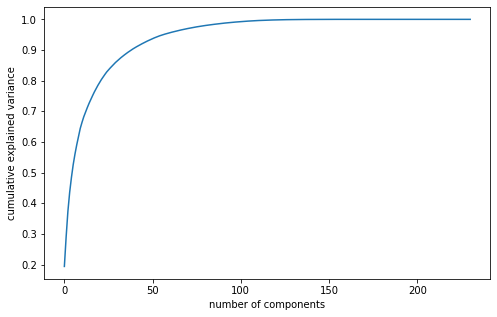

In [78]:
#Screeplot for the PCA components
%matplotlib inline
fig = plt.figure(figsize = (8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

Chosen 50 PCA components for model building

In [79]:
# Initialize pca with 50 components
pca = PCA(n_components=50, random_state=RANDOM_STATE)
# fit and transform the training dataset
X_train_pca = pca.fit_transform(X_train)
# transform the testing dataset
X_test_pca = pca.transform(X_test)
# fit and transform the whole dataset
X_pca = pca.fit_transform(X)

# Baseline Model Building

In [80]:
# List to store the model scores
model_score_list = []

In [81]:
def evaluate_model(actual, pred):
    '''
    - This method gets 2 series (actual and predicted) as inputs and compute the accuracy, ROC, Precision and Recall scores  
    - Then returns the computed scores. 
    '''
    # Accuracy Score
    acc_score = round(accuracy_score(actual, pred)*100,2)
    print('Accuracy Score : ',acc_score)
    # ROC AUC score
    roc_score = round(roc_auc_score(actual, pred)*100,2)
    print('ROC AUC score : ',roc_score)
    # Precision score
    prec_score = round(precision_score(actual, pred)*100,2)
    print('Precision score : ', prec_score)
    # Recall score
    rec_score = round(recall_score(actual, pred)*100,2)
    print('Recall score : ', rec_score)

    return acc_score, roc_score, prec_score, rec_score

### Logistic Regression

In [82]:
# Initialize the Logistic regression
model = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the testing pca data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list 
model_score_list.append({'model_name':'LogisticRegression', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  99.88
ROC AUC score :  99.88
Precision score :  99.82
Recall score :  99.95


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### RidgeClassifier

In [83]:
# initialize the Ridge Classifier
model = RidgeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'RidgeClassifier', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  99.36
ROC AUC score :  99.36
Precision score :  98.74
Recall score :  100.0


### SGDClassifier

In [84]:
# initialize the SGDClassifier
model = SGDClassifier(class_weight='balanced', random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'SGDClassifier', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  99.83
ROC AUC score :  99.83
Precision score :  99.85
Recall score :  99.82


### KNN

In [85]:
# initialize the KNeighbors classifiers
model = KNeighborsClassifier()
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'KNeighborsClassifier', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  99.48
ROC AUC score :  99.47
Precision score :  98.97
Recall score :  100.0


### LinearSVC

In [86]:
# initialize the LinearSVC
model = LinearSVC(class_weight='balanced', random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'LinearSVC', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  99.84
ROC AUC score :  99.84
Precision score :  99.87
Recall score :  99.82


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


### SVC

In [87]:
# initialize the SVC rbf kernel
model = SVC(kernel='rbf', class_weight='balanced', random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'SVC_Kernel_rbf', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  99.85
ROC AUC score :  99.85
Precision score :  99.7
Recall score :  100.0


### Decision Tree

In [88]:
# initialize the Decision Tree
model = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'DecisionTreeClassifier', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  99.18
ROC AUC score :  99.18
Precision score :  98.88
Recall score :  99.5


### RandomForest

In [89]:
# initialize the randomforest
model = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'RandomForestClassifier', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  99.68
ROC AUC score :  99.68
Precision score :  99.43
Recall score :  99.93


### ExtraTrees

In [90]:
# initialize the ExtraTreesClassifier
model = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'ExtraTreesClassifier', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  99.89
ROC AUC score :  99.89
Precision score :  99.82
Recall score :  99.97


### ADABoost

In [91]:
# initialize the AdaBoost
model = AdaBoostClassifier(random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'AdaBoostClassifier', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  99.29
ROC AUC score :  99.29
Precision score :  99.1
Recall score :  99.5


### GradientBoosting

In [92]:
# initialize the GradientBoosting
model = GradientBoostingClassifier(random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'GradientBoostingClassifier', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  99.37
ROC AUC score :  99.37
Precision score :  98.98
Recall score :  99.76


### XGBoosting

In [93]:
# Initialize the XGBoost
model = XGBClassifier(random_state=RANDOM_STATE)
# fit the pca training data
model.fit(X_train_pca, Y_train)
# predict the pca testing data
Y_pred = model.predict(X_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'XGBClassifier', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  99.55
ROC AUC score :  99.55
Precision score :  99.28
Recall score :  99.83


### Model score list

Let's view the models score list to select the top models

In [94]:
# convert the model scores to dataframe
model_score_df = pd.DataFrame(model_score_list,columns=['model_name', 'acc_score', 'roc_score','precision_score','recall_score'])

# Order by highest recall score and roc_auc_score
model_score_df.sort_values(['recall_score','roc_score'], ascending=False)

,model_name,acc_score,roc_score,precision_score,recall_score
5,SVC_Kernel_rbf,99.85,99.85,99.70,100.00
3,KNeighborsClassifier,99.48,99.47,98.97,100.00
1,RidgeClassifier,99.36,99.36,98.74,100.00
8,ExtraTreesClassifier,99.89,99.89,99.82,99.97
0,LogisticRegression,99.88,99.88,99.82,99.95
7,RandomForestClassifier,99.68,99.68,99.43,99.93
11,XGBClassifier,99.55,99.55,99.28,99.83
4,LinearSVC,99.84,99.84,99.87,99.82
2,SGDClassifier,99.83,99.83,99.85,99.82
10,GradientBoostingClassifier,99.37,99.37,98.98,99.76


### Top 3 Models based on recall_score are KNeighborsClassifier, SVC_Kernel_rbf and ExtraTreesClassifier

##### KNeighborsClassifier
- Variation between recall_score and precision_score seem to be high at about 17%.
- But recall_score is almost 100% and the roc_auc_score is bit low at 89% comparing to other top two classifiers

##### SVC_Kernel_rbf
- There is a moderate variation between recall_score and precision_score.
- The recall_score is about 97.5% and the roc_auc_score is about 94.5% 

##### ExtraTreesClassifier
- There is no much variation in recall and precision score.
- Also The recall_score and the roc_auc_score is around 95.5% which seem to be constant.

**Let's check for the overfitting among the top 3 models using cross validation and select a model**

# Cross Validation and Model Selection

Now we will do the cross validation for the top 3 models and select a model based on the mean score

In [95]:
# initialize Stratified KFold with 5 splits
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state = RANDOM_STATE)

# Cross validation for KNeighborsClassifier
model = KNeighborsClassifier()
knn_cv_scores = cross_val_score(model, X_pca, Y, scoring='recall', cv = skf, n_jobs=-1)
print('KNeighborsClassifier cv_score_mean : ', round(knn_cv_scores.mean() * 100, 2))
print('KNeighborsClassifier cv_score_std : ', round(knn_cv_scores.std() * 100, 2))

# Cross validation for SVC_Kernel_rbf
model = SVC(kernel='rbf', random_state=RANDOM_STATE)
svc_cv_scores = cross_val_score(model, X_pca, Y, scoring='recall', cv = skf, n_jobs=-1)
print('SVC_Kernel_rbf cv_score_mean : ', round(svc_cv_scores.mean() * 100, 2))
print('SVC_Kernel_rbf cv_score_std : ', round(svc_cv_scores.std() * 100, 2))

# Cross validation for ExtraTreesClassifier
model = ExtraTreesClassifier(random_state=RANDOM_STATE)
etc_cv_scores = cross_val_score(model, X_pca, Y, scoring='recall', cv = skf, n_jobs=-1)
print('ExtraTreesClassifier cv_score_mean : ', round(etc_cv_scores.mean() * 100, 2))
print('ExtraTreesClassifier cv_score_std : ', round(etc_cv_scores.std() * 100, 2))


KNeighborsClassifier cv_score_mean :  100.0
KNeighborsClassifier cv_score_std :  0.0
SVC_Kernel_rbf cv_score_mean :  100.0
SVC_Kernel_rbf cv_score_std :  0.0
ExtraTreesClassifier cv_score_mean :  100.0
ExtraTreesClassifier cv_score_std :  0.0


### Plot the cv scores for the above 3 models

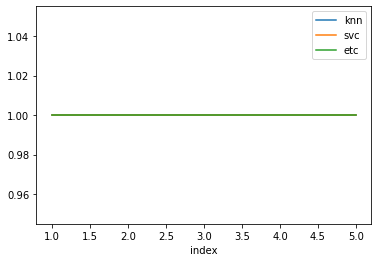

In [96]:
# plot the cv scores for the above 3 models
cv_scores_df = pd.DataFrame({'index':np.linspace(1,n_splits,n_splits),'knn':knn_cv_scores,'svc':svc_cv_scores,'etc':etc_cv_scores})
cv_scores_df.plot.line(x='index', y=['knn','svc','etc'])


### Cross Validation results
##### KNeighborsClassifier
- Recall score is very consistent amoung all the folds

##### SVC_Kernel_rbf
- This model seem to have lot of variations in recall score and have overfit problem.

##### ExtraTreesClassifier
- This model has little bit of variations in recall score among all the folds validation.

**Since it is more important to identify churners than the non-churners accurately, we go with the KNeighborsClassifier which is consistent and also has high recall score**

# Hyperparameter Tuning for KNeighborsClassifier

Next we will tune the hyperparameters for the KNeighborsClassifier to find the best estimator

In [97]:
help(KNeighborsClassifier)

Help on class KNeighborsClassifier in module sklearn.neighbors._classification:

class KNeighborsClassifier(sklearn.neighbors._base.KNeighborsMixin, sklearn.base.ClassifierMixin, sklearn.neighbors._base.NeighborsBase)
 |  KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
 |  
 |  Classifier implementing the k-nearest neighbors vote.
 |  
 |  Read more in the :ref:`User Guide <classification>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, default=5
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : {'uniform', 'distance'} or callable, default='uniform'
 |      Weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by the inverse of their distance.
 |        in this case, closer neighbors of

In [98]:
# Hyperparameter Tuning for KNeighborsClassifier
# number of folds
n_splits = 5
# Number of neighbors
n_neighbors =  [int(x) for x in np.linspace(start = 1, stop = 3, num = 3)]
# Power parameter for the distance metric
p = [int(x) for x in np.linspace(start = 1, stop = 3, num = 3)]

# Create the parameter grid
params = {
            'n_neighbors': n_neighbors,
            'p': p
         }

# initialize the KNN model
model = KNeighborsClassifier(weights='uniform', n_jobs=-1)

# initialize the StratifiedKFold 
skf = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state = RANDOM_STATE)

# initialize the RandomSearchCV
#grid = GridSearchCV(estimator=model, param_grid=params, scoring='recall', n_jobs=-1, cv=skf.split(X,Y), verbose=3 )
grid = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter = 1, scoring='recall', n_jobs=-1, cv=skf.split(X_pca,Y), verbose=3, random_state=RANDOM_STATE )

# fit the whole pca dataset
grid.fit(X_pca, Y)

# print the grid results
print('\n Best estimator:')
print(grid.best_estimator_)
print('\n Best score:')
print(grid.best_score_ * 2 - 1)
print('\n Best parameters:')
print(grid.best_params_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits

 Best estimator:
KNeighborsClassifier(n_jobs=-1, n_neighbors=3)

 Best score:
1.0

 Best parameters:
{'p': 2, 'n_neighbors': 3}


**The best recall score we got using RandomSearch is 99.89% and best param is p=2 with n_neighbors=3.**

**Now let's try fitting the best estimator and predict the results**


# Fitting the Best Estimator

In [99]:
# initialize the model with the best estimor
model = grid.best_estimator_

# fit the pca training dataset
model.fit(X_train_pca, Y_train)

# Predict the model with the pca testing dataset
Y_pred = model.predict(X_test_pca)

# get the predict probablities of pca testing dataset
Y_pred_proba = model.predict_proba(X_test_pca)

# Model Evaluation

In [100]:
def draw_roc( actual, probs ):
    '''
    - This method reads the Actual and predicted series of values
    - Compute the roc_auc values
    - Compute the roc_auc_score 
    - Then plot the roc_auc curve. 
    '''
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [101]:
# Classification Report
print('\nClassification Report : \n\n', classification_report(Y_test, Y_pred))

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
print('\nTN = {0}, FP = {1}, FN = {2}, TP = {3}\n\n'.format(tn, fp, fn, tp))

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)


Classification Report : 

               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      5898
         1.0       0.99      1.00      1.00      5948

    accuracy                           1.00     11846
   macro avg       1.00      1.00      1.00     11846
weighted avg       1.00      1.00      1.00     11846


TN = 5845, FP = 53, FN = 0, TP = 5948


Accuracy Score :  99.55
ROC AUC score :  99.55
Precision score :  99.12
Recall score :  100.0


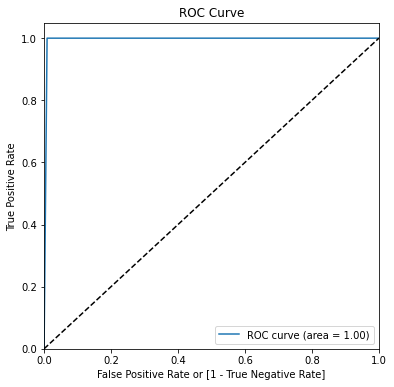

In [102]:
# ROC-AUC curve
draw_roc(Y_test, Y_pred)

We have got the **recall score of 99.93%** with the best estimator which is slightly better than the Cross Validation mean score. Also the above Roc Curve seems to be in a good shape.

Nows let's see if we can optimize the cutoff further to **minimize the False Negatives**

### Optimal probability cutoff to minimize False Negatives

In [103]:
# Frame the dataset with the predicted probabilities
Y_pred_final = pd.DataFrame({'actual':Y_test,'pred_nonchurn_prob':Y_pred_proba[:,0],'pred_churn_prob':Y_pred_proba[:,1],'predicted':Y_pred})
Y_pred_final.head(5)

,actual,pred_nonchurn_prob,pred_churn_prob,predicted
22446,1.0,0.0,1.0,1.0
24030,1.0,0.0,1.0,1.0
8618,0.0,1.0,0.0,0.0
33411,1.0,0.0,1.0,1.0
32694,1.0,0.0,1.0,1.0


In [104]:
# create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    Y_pred_final[i]= Y_pred_final['pred_churn_prob'].map( lambda x: 1 if x > i else 0)
Y_pred_final.head()

,actual,pred_nonchurn_prob,pred_churn_prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
22446,1.0,0.0,1.0,1.0,1,1,1,1,1,1,1,1,1,1
24030,1.0,0.0,1.0,1.0,1,1,1,1,1,1,1,1,1,1
8618,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0
33411,1.0,0.0,1.0,1.0,1,1,1,1,1,1,1,1,1,1
32694,1.0,0.0,1.0,1.0,1,1,1,1,1,1,1,1,1,1


In [105]:
# calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix( Y_pred_final['actual'], Y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi  speci
0.0   0.0  0.993331  0.986606    1.0
0.1   0.1  0.993331  0.986606    1.0
0.2   0.2  0.993331  0.986606    1.0
0.3   0.3  0.993331  0.986606    1.0
0.4   0.4  0.995526  0.991014    1.0
0.5   0.5  0.995526  0.991014    1.0
0.6   0.6  0.995526  0.991014    1.0
0.7   0.7  0.997299  0.994574    1.0
0.8   0.8  0.997299  0.994574    1.0
0.9   0.9  0.997299  0.994574    1.0


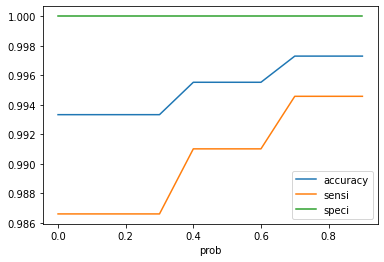

In [106]:
# plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])

#### Now let's try with the cutoff of 0.3 and see if the False negatives can be reduced.

In [107]:
Y_pred_final['final_predicted'] = Y_pred_final['pred_churn_prob'].map( lambda x: 1 if x > 0.3 else 0)

# Final Model Evaluation

In [108]:
# Classification Report
print('\nClassification Report : \n\n', classification_report(Y_test, Y_pred_final['final_predicted']))

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_final['final_predicted']).ravel()
print('\nTN = {0}, FP = {1}, FN = {2}, TP = {3}\n\n'.format(tn, fp, fn, tp))

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred_final['final_predicted'])


Classification Report : 

               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      5898
         1.0       0.99      1.00      0.99      5948

    accuracy                           0.99     11846
   macro avg       0.99      0.99      0.99     11846
weighted avg       0.99      0.99      0.99     11846


TN = 5819, FP = 79, FN = 0, TP = 5948


Accuracy Score :  99.33
ROC AUC score :  99.33
Precision score :  98.69
Recall score :  100.0


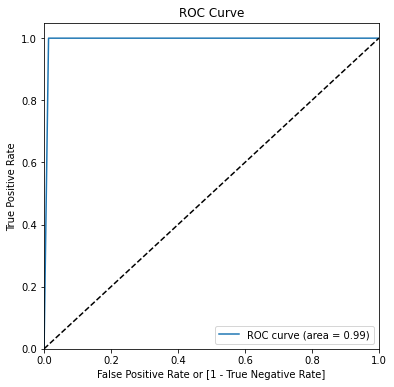

In [109]:
# ROC-AUC curve
draw_roc(Y_test, Y_pred_final['final_predicted'])

### Observation

When the churn prediction probablity is at 0.5, we have 7 churned customers predicted as non churned and 1643 non churned customer predicted as churned. 

To make the 7 churned customers as churned, we have to adjust the probablity cutoff to 0.3 which increases the non churned customers predicted as churned to 2561 which is a considerable amount of increase in False Positive rate. 

**So we would recommend to go with the probablity cutoff of 0.5 as final prediction.**

# Model 2 - Identifying Strong Predictors of churn (Important features)

# Feature Selection using ExtraTreesClassifier

Let's prepare the dataset for model building

In [110]:
# Get the copy of the master_df and assign it in the dataset
train_df = master_df.copy()

churn = train_df['churn']
train_df = train_df.drop('churn', axis=1)

# train_df = train_df.fillna(0)
print(train_df.isnull().values.any())

X = train_df
Y = churn

False


Next, we we'll fit the dataset in ExtraTreesClassifier and check for the features importance

In [111]:
# Fit the ExtraTreesClassifier model with default params
model = ExtraTreesClassifier(n_jobs=-1, random_state=RANDOM_STATE)
model.fit(X, Y)

# Check the feature importance score for each feature
feature_imp_df = pd.DataFrame({'Feature':train_df.columns, 'Score':model.feature_importances_})
# Order the features by max score
feature_imp_df = feature_imp_df.sort_values('Score', ascending=False).reset_index()
feature_imp_df.head(50)

,index,Feature,Score
0,205,total_ic_weightage,0.217581
1,207,total_og_weightage,0.202813
2,92,spl_ic_mou_8,0.057223
3,236,rech_amt_weightage,0.051984
4,50,isd_og_mou_8,0.045119
5,160,churn_probability,0.036407
6,155,fb_user_8,0.022770
7,243,fb_user_weightage,0.019635
8,196,mean_isd_og_mou,0.016770
9,198,mean_spl_ic_mou,0.010686


Now we will plot the top 50 important features with scores 

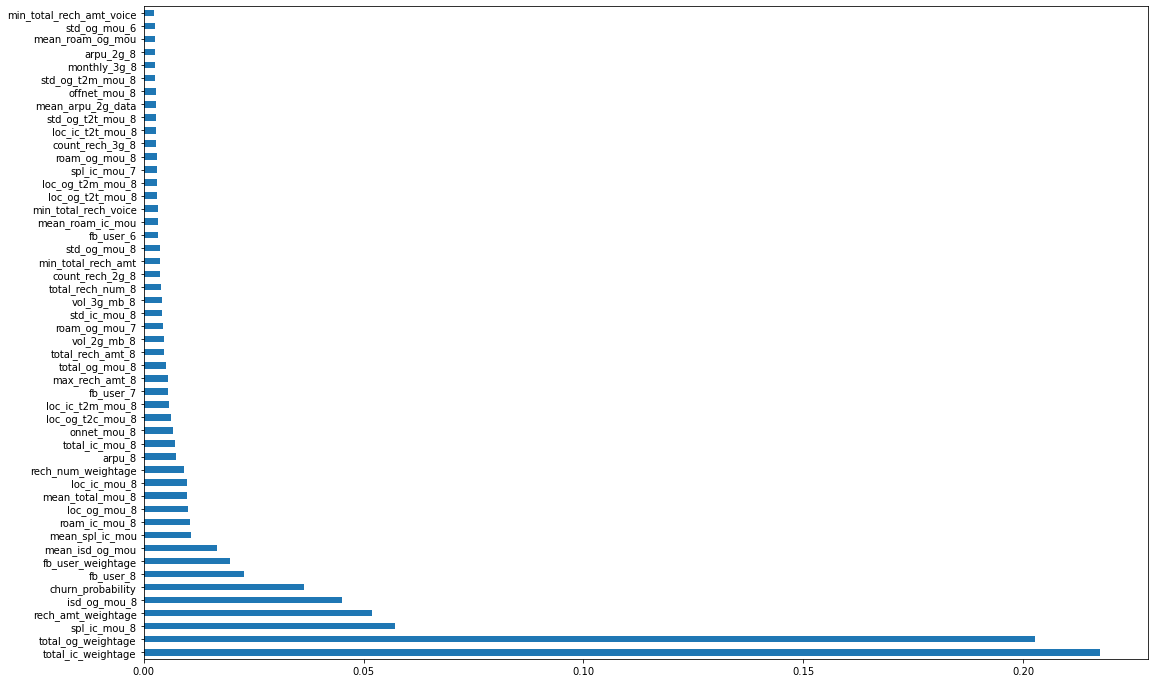

In [112]:
# plot the chart with top 50 important features
(pd.Series(model.feature_importances_, index=train_df.columns)
   .nlargest(50)
   .plot(kind='barh', figsize=(18,12))) 

Also plot the heat map for the top 50 features to check for the correlation between the independent features 

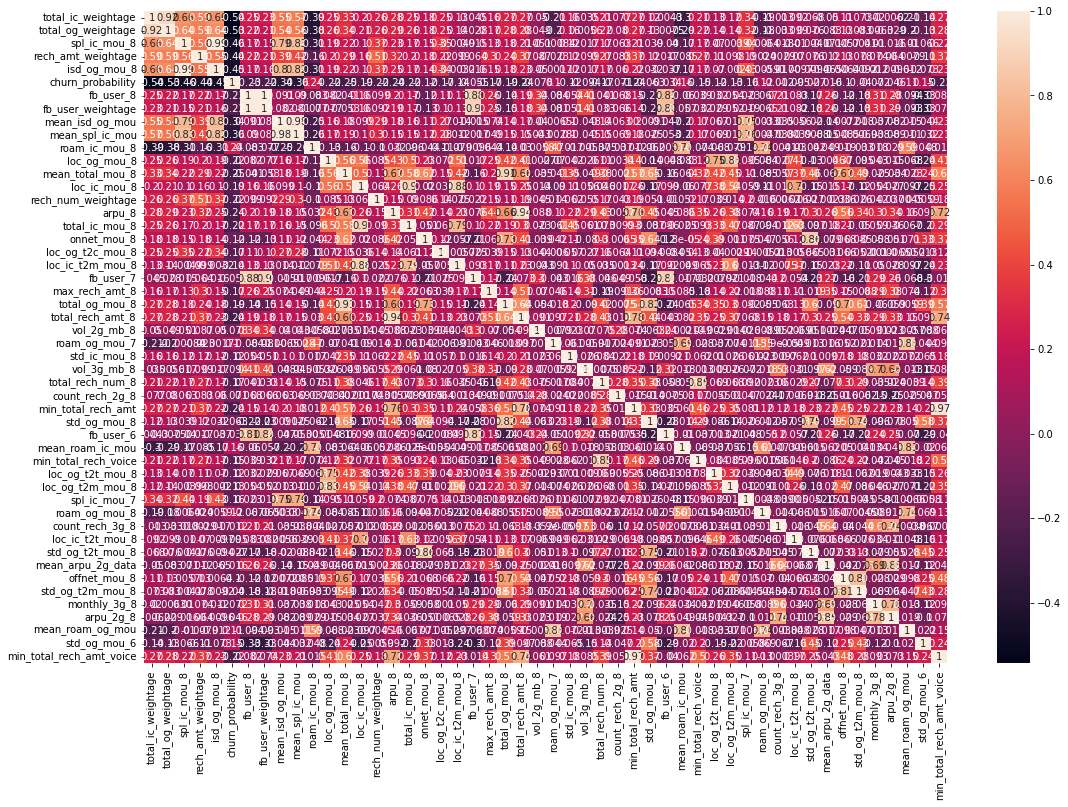

In [113]:
# Heatmap with top 50 features
top_50_features = feature_imp_df[:50]['Feature']
plt.figure(figsize=(18,12))
sns.heatmap(train_df[top_50_features].corr(), annot=True)

* Now we we'll select only the uncorrelated features from the top 50 features.
* Then we we'll fit the generalized linear model to check the significance of each feature for the model.
* Remove the features with high P-Value to handle the multicollinearity

In [114]:
#selected the uncorrelated features from the top 50 features
cols = ['total_og_weightage','max_rech_amt_8','loc_og_t2m_mou_8','roam_og_mou_8',
        'total_og_mou_8','total_rech_num_8','arpu_8','fb_user_weightage','aon']

X = train_df[cols]
Y = churn

# fit the data in GLM model
logm = sm.GLM(Y,(sm.add_constant(X)), family = sm.families.Binomial())
modres = logm.fit()
# print the summary results
logm.fit().summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/links.py:190: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:889: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:942: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:942: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20951
Model:                            GLM   Df Residuals:                    20941
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 10 Aug 2022   Deviance:                          nan
Time:                        17:07:24   Pearson chi2:                 1.13e+04
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  6.8682      0.543     12.660      0.000       5.805       7.932
total_og_weightage -8.785e-05      0.029     -0.003      0.998      -0.056       0.056
max_rech_amt_8        -0.0033      0.001     -3.226      0.001      -0.005      -0.001
loc_og_t2m_mou_8       0.0162      0.002      8.038      0.000       0.012       0.020
roam_og_mou_8          0.0061      0.002      3.614      0.000       0.003       0.009
total_og_mou_8      -869.7908    527.341     -1.649      0.099   -1903.361     163.779
total_rech_num_8      -0.0094      0.042     -0.220      0.826      -0.093       0.074
arpu_8              6.781e-05      0.001      0.093      0.926      -0.001       0.001
fb_user_weightage     -0.0919      0.006    -15.977      0.000      -0.103      -0.081
aon                   -0.0003      0.000     -1.563      0.118      -0.001    7.35e-05
======================================================================================
"""

In [119]:
remove = ['total_ic_weightage', 'total_og_weightage', 'rech_amt_weightage', 'churn_probability', 'fb_user_weightage', 'mean_isd_og_mou', 'mean_spl_ic_mou', 'mean_total_mou_8', 'rech_num_weightage', 'min_total_rech_amt', 'mean_roam_ic_mou', 'min_total_rech_voice', 'mean_arpu_2g_data', 'mean_roam_og_mou', 'min_total_rech_amt_voice']
new_col = list(set(top_50_features) - set(remove))
len(new_col)

35

In [120]:
#selected features with less p-value
train_df = train_df[new_col]

### Standardize the numerical features

Now, we'll standardize(rescale) the numerical features so as to have mean as 0 and SD as 1

In [121]:
#Standardize the numeric values
train_df = ((train_df - train_df.mean() ) / train_df.std())

# Handle class imbalance using SMOTE or ADASYN

In [122]:
# Prepare the data
X = train_df
Y = churn

# Handle class imbalance
smote = SMOTE(random_state=RANDOM_STATE)
X, Y = smote.fit_resample(X, Y)

# adasyn = ADASYN(random_state=RANDOM_STATE)
# X, Y = adasyn.fit_sample(X, Y)

print('Class Balance count : ',Counter(Y))


Class Balance count :  Counter({0.0: 19743, 1.0: 19743})


# Split into train test 

In [123]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=RANDOM_STATE)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(27640, 35) (27640,)
(11846, 35) (11846,)


In [124]:
print('Y_train :', Counter(Y_train))
print('Y_test :', Counter(Y_test))

Y_train : Counter({0.0: 13845, 1.0: 13795})
Y_test : Counter({1.0: 5948, 0.0: 5898})


Note that the class is well balanced now. We can now split the train and test dataset.

# Model Building

### ExtraTrees

In [125]:
model = ExtraTreesClassifier(bootstrap=False, class_weight='balanced', criterion='gini', max_depth=60, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, 
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1, oob_score=False, random_state=RANDOM_STATE, verbose=0, warm_start=False)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

# Model Evaluation

In [126]:
# Classification Report
print('\nClassification Report : \n\n', classification_report(Y_test, Y_pred))

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
print('\nTN = {0}, FP = {1}, FN = {2}, TP = {3}\n\n'.format(tn, fp, fn, tp))

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)


Classification Report : 

               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5898
         1.0       1.00      1.00      1.00      5948

    accuracy                           1.00     11846
   macro avg       1.00      1.00      1.00     11846
weighted avg       1.00      1.00      1.00     11846


TN = 5896, FP = 2, FN = 0, TP = 5948


Accuracy Score :  99.98
ROC AUC score :  99.98
Precision score :  99.97
Recall score :  100.0


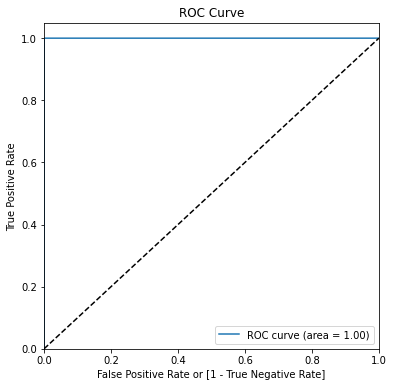

In [127]:
# ROC-AUC curve
draw_roc(Y_test, Y_pred)

We are able to achieve the **Recall Score of 98.98%** with the selected features. Also the above ROC curve seems to be in a good shape. 

# Strategy recommendation to manage customer churn

#### Features contribution plot

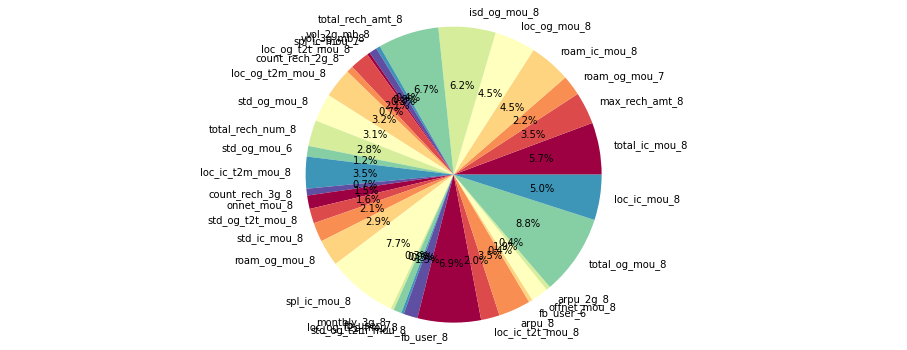

In [128]:
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 9)]

plt.figure(figsize=(16,6))
plt.pie(model.feature_importances_, labels=train_df.columns, autopct='%1.1f%%', shadow=False, colors=colors)
plt.axis('equal')
plt.show()

#### Featurewise churn plot

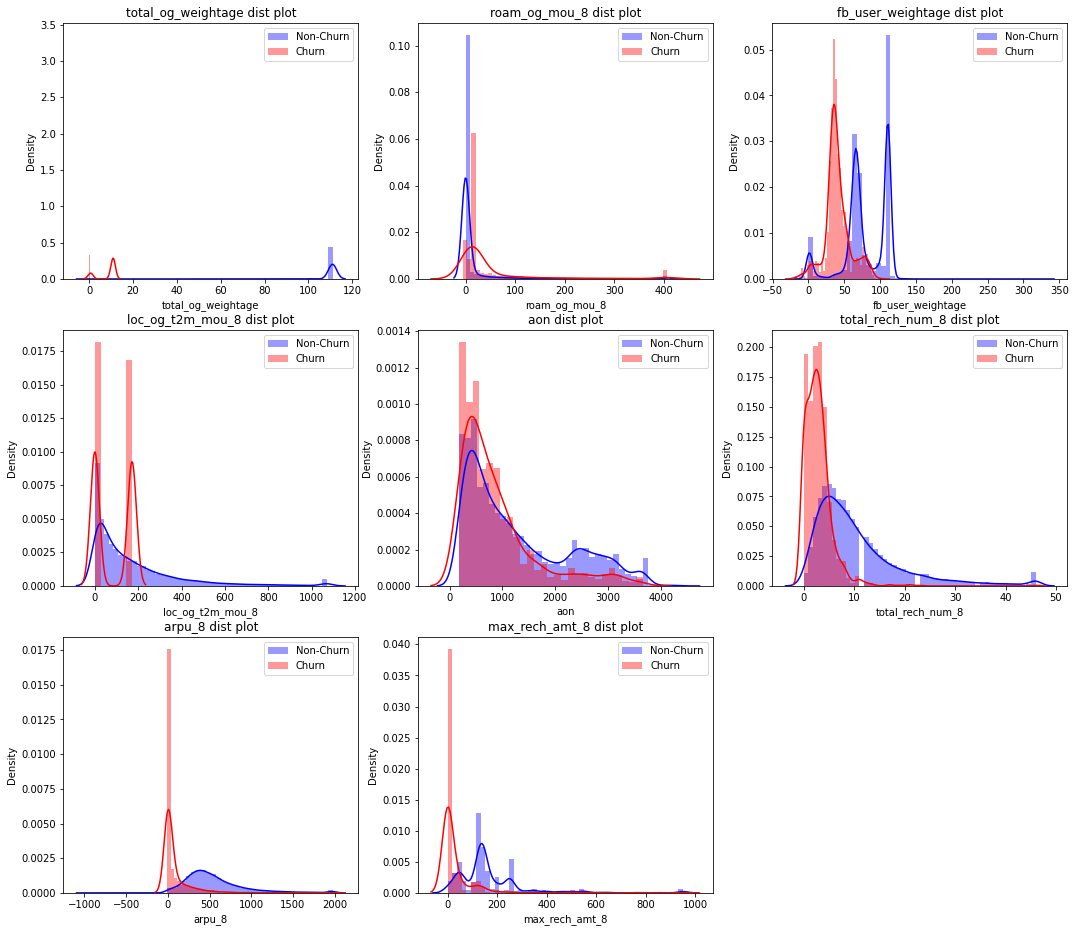

In [129]:
# Data preparation
train_df = master_df.copy()

#selected final list of features
cols = ['total_og_weightage','roam_og_mou_8','fb_user_weightage','loc_og_t2m_mou_8','aon',
        'total_rech_num_8','arpu_8','max_rech_amt_8']

train_df = train_df[cols]
train_df['churn'] = master_df['churn']

plt.figure(figsize=(18,16))

for i, col in enumerate(cols):

    plt.subplot(3,3,i+1)
    ax = sns.distplot(train_df.loc[train_df['churn']==0, [col]], color='b', label='Non-Churn')
    ax = sns.distplot(train_df.loc[train_df['churn']==1, [col]], color='r', label='Churn')
    ax.legend()
    plt.xlabel(col)
    plt.title('{0} dist plot'.format(col))

### Processing with Test Dataset

In [130]:
test_df = pd.read_csv('/content/test (1).csv.zip')
test_df.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


In [131]:
test_df.isnull().sum()

id                    0
circle_id             0
loc_og_t2o_mou      316
std_og_t2o_mou      316
loc_ic_t2o_mou      316
                  ...  
fb_user_8         22078
aon                   0
aug_vbc_3g            0
jul_vbc_3g            0
jun_vbc_3g            0
Length: 171, dtype: int64

In [132]:
a = test_df['id']

In [133]:
len(X.columns)

35

In [135]:
test_df = test_df[X.columns]

In [136]:
test_df.isnull().sum()

total_ic_mou_8          0
max_rech_amt_8          0
roam_og_mou_7        1172
roam_ic_mou_8        1675
loc_og_mou_8         1675
isd_og_mou_8         1675
total_rech_amt_8        0
vol_2g_mb_8             0
vol_3g_mb_8             0
spl_ic_mou_7         1172
loc_og_t2t_mou_8     1675
count_rech_2g_8     22078
loc_og_t2m_mou_8     1675
std_og_mou_8         1675
total_rech_num_8        0
std_og_mou_6         1169
loc_ic_t2m_mou_8     1675
count_rech_3g_8     22078
onnet_mou_8          1675
std_og_t2t_mou_8     1675
std_ic_mou_8         1675
roam_og_mou_8        1675
spl_ic_mou_8         1675
monthly_3g_8            0
fb_user_7           22294
loc_og_t2c_mou_8     1675
std_og_t2m_mou_8     1675
fb_user_8           22078
loc_ic_t2t_mou_8     1675
arpu_8                  0
fb_user_6           22415
offnet_mou_8         1675
arpu_2g_8           22078
total_og_mou_8          0
loc_ic_mou_8         1675
dtype: int64

In [137]:
percent_null = test_df.isnull().sum().sum() / np.product(test_df.shape) * 100
percent_null

15.715142857142858

In [138]:
for col in test_df.columns:
    null_col = test_df[col].isnull().sum() / test_df.shape[0] * 100
    print("{} : {:.2f}".format(col,null_col))

total_ic_mou_8 : 0.00
max_rech_amt_8 : 0.00
roam_og_mou_7 : 3.91
roam_ic_mou_8 : 5.58
loc_og_mou_8 : 5.58
isd_og_mou_8 : 5.58
total_rech_amt_8 : 0.00
vol_2g_mb_8 : 0.00
vol_3g_mb_8 : 0.00
spl_ic_mou_7 : 3.91
loc_og_t2t_mou_8 : 5.58
count_rech_2g_8 : 73.59
loc_og_t2m_mou_8 : 5.58
std_og_mou_8 : 5.58
total_rech_num_8 : 0.00
std_og_mou_6 : 3.90
loc_ic_t2m_mou_8 : 5.58
count_rech_3g_8 : 73.59
onnet_mou_8 : 5.58
std_og_t2t_mou_8 : 5.58
std_ic_mou_8 : 5.58
roam_og_mou_8 : 5.58
spl_ic_mou_8 : 5.58
monthly_3g_8 : 0.00
fb_user_7 : 74.31
loc_og_t2c_mou_8 : 5.58
std_og_t2m_mou_8 : 5.58
fb_user_8 : 73.59
loc_ic_t2t_mou_8 : 5.58
arpu_8 : 0.00
fb_user_6 : 74.72
offnet_mou_8 : 5.58
arpu_2g_8 : 73.59
total_og_mou_8 : 0.00
loc_ic_mou_8 : 5.58


In [139]:
for col in test_df.columns:
    null_col = test_df[col].isnull().sum() / test_df.shape[0] * 100
    if null_col > 0:
        test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

In [140]:
test_df.isnull().sum().sum()

0

In [141]:
test_df = ((test_df - test_df.mean() ) / test_df.std())

In [142]:
test_df = test_df.fillna(0)
test_df.isnull().values.any()

False

In [143]:
probabilities = model.predict(test_df)


In [144]:
len(probabilities)

30000

In [145]:
len(a)

30000

In [146]:
test_df.head()

,total_ic_mou_8,max_rech_amt_8,roam_og_mou_7,roam_ic_mou_8,loc_og_mou_8,isd_og_mou_8,total_rech_amt_8,vol_2g_mb_8,vol_3g_mb_8,spl_ic_mou_7,...,loc_og_t2c_mou_8,std_og_t2m_mou_8,fb_user_8,loc_ic_t2t_mou_8,arpu_8,fb_user_6,offnet_mou_8,arpu_2g_8,total_og_mou_8,loc_ic_mou_8
0,-0.559340,-0.589641,-0.164013,-0.081800,-0.436690,-0.056480,-0.673773,-0.238717,-0.252359,1.631897,...,-0.190018,-0.211154,0.171378,-0.181084,-0.659852,0.152631,-0.459965,-0.249323,-0.512398,-0.513755
1,0.282198,1.069907,-0.164013,-0.081800,1.079626,0.014599,0.445442,-0.238717,-0.252359,-0.173965,...,-0.194233,-0.243717,0.171378,-0.337006,0.248204,0.152631,0.638151,-0.249323,0.234802,0.115860
2,-0.683685,2.955757,0.774349,0.201798,-0.558059,-0.056480,1.717277,-0.238717,-0.252359,-0.173965,...,-0.194233,-0.309514,0.171378,-0.358015,1.428741,0.152631,-0.428831,-0.249323,-0.633446,-0.640994
3,1.199420,-0.815943,-0.164013,-0.081800,-0.463784,-0.056480,-0.826393,-0.238717,-0.252359,-0.173965,...,-0.194233,-0.309514,0.171378,-0.172551,-0.782525,0.152631,-0.492959,-0.249323,-0.583284,1.505802
4,-0.137542,0.164699,-0.164013,-0.081800,-0.452856,-0.056480,0.562451,-0.238717,-0.252359,-0.173965,...,-0.194233,-0.074387,0.171378,-0.278243,0.408911,0.152631,-0.340032,-0.249323,0.995665,-0.569884


In [147]:
submission = pd.DataFrame({'id':a,'churn_probability':probabilities})

In [148]:
submission['churn_probability'] = submission['churn_probability'].astype('int')

In [149]:
submission.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [150]:
submission.to_csv('Submission.csv',index=False)


# Conclusion
**The observation on the important predictors of customer churn is as follows,**
##### days_since_last_rech
- Represents the number of days since last recharge. Lower value has got high churn rate.

##### total_og_weightage
- Represents the total outgoing minutes of usage for the last 3 months with the increasing weightage. Lower value comparatively got more churn than the other. 

##### roam_og_mou_8
- Represents the total outgoing minutes of usage on roaming in the recent month. Lower the value higher the churn rate.

##### fb_user_weightage
- Represents the fb user pack usage for the last 3 months with the increasing weightage. Higher the value higher the churn rate.

##### loc_og_t2m_mou_8
- Represents the total outgoing minutes of usage calls to other mobiles in the recent month. Lower value has got high churn rate.

##### aon
- Represents the age on netwok for the last 3 months. Lower value comparatively got more churn than the other.

##### total_rech_num_8
- Represents the total number of times recharged in the recent month. Lower the value higher the churn rate.

##### arpu_8
- Represents the average revenue per user in the recent month. Lower value has got high churn rate. 

##### max_rech_amt_8
- Represents the maximum recharged amount in the recent month. Lower value comparatively got more churn than the other.

## Hence we recommend the Telecom company to consider these driver variables which are strong indicators to manage customer churn.   